In [2]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import category_encoders as ce
import os
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
import random
random.seed(21)

import json
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor
import keras_tuner as kt
from tensorflow.keras import layers, regularizers, optimizers


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras import activations
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Step 1. Data overview and processing

## 1.1 Reading data from dataset and common overview

In [35]:
data=pd.read_csv('/kaggle/input/car-data/gcar_data.csv')

In [36]:
data.columns

Index(['Unnamed: 0', 'brand', 'model', 'color', 'registration_date', 'year',
       'price_in_euro', 'power_kw', 'power_ps', 'transmission_type',
       'fuel_type', 'fuel_consumption_l_100km', 'fuel_consumption_g_km',
       'mileage_in_km', 'offer_description'],
      dtype='object')

In [38]:
data.head(3)

Unnamed: 0    brand           model  color registration_date  year  \
0       75721     ford       Ford Kuga  black           05/2023  2023   
1       80184  hyundai     Hyundai i10  black           09/2018  2018   
2       19864     audi  Audi Q4 e-tron   grey           05/2021  2021   

  price_in_euro power_kw power_ps transmission_type fuel_type  \
0         38490      140      190         Automatic    Hybrid   
1         11555       49       67            Manual    Petrol   
2         48886      125      170         Automatic  Electric   

  fuel_consumption_l_100km fuel_consumption_g_km  mileage_in_km  \
0             5,4 l/100 km              124 g/km          100.0   
1             4,6 l/100 km              106 g/km        27782.0   
2                      NaN                0 g/km         4247.0   

                                offer_description  
0  ST-Line Hybrid Adapt.LED+Head-Up-Display Klima  
1             blue Trend,Viele Extras,Top-Zustand  
2    35 e-tron S line/Matrix/Pano/ACC/SONOS/LM 21

In [39]:
data.shape

(100000, 15)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                100000 non-null  int64  
 1   brand                     100000 non-null  object 
 2   model                     100000 non-null  object 
 3   color                     99924 non-null   object 
 4   registration_date         99999 non-null   object 
 5   year                      100000 non-null  object 
 6   price_in_euro             100000 non-null  object 
 7   power_kw                  99925 non-null   object 
 8   power_ps                  99928 non-null   object 
 9   transmission_type         100000 non-null  object 
 10  fuel_type                 100000 non-null  object 
 11  fuel_consumption_l_100km  88761 non-null   object 
 12  fuel_consumption_g_km     100000 non-null  object 
 13  mileage_in_km             99932 non-null   fl

In [41]:
data.isnull().sum()

Unnamed: 0                      0
brand                           0
model                           0
color                          76
registration_date               1
year                            0
price_in_euro                   0
power_kw                       75
power_ps                       72
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    11239
fuel_consumption_g_km           0
mileage_in_km                  68
offer_description               0
dtype: int64

In [42]:
data.duplicated().sum()

0

## 1.2 Removing extra data

Deleting unnessesary columns

In [43]:
def remove_cols(data, cols):
    data.drop(columns=cols, inplace=True)

In [44]:
# Unnamed - unique ID
# registration_date - not an important car feature, in addition there is creation year
# power_kw - same property as power_ps
# fuel_consumption_g_km - same as fuel_consumption_l_100km
# offer_description - large and unstructured additional info

cols_to_remove = ['Unnamed: 0',
                  'registration_date',
                  'power_kw',
                  'fuel_consumption_g_km',
                  'offer_description']

remove_cols(data, cols_to_remove)

Removing brand from model name

In [45]:
data['model'] = data['model'].apply(lambda x: ' '.join(x.split()[1:]))

## 1.3 Translating object data to numbers where nessesary

In [46]:
def col_to_numeric(data, col_name):
    data[col_name] = pd.to_numeric(data[col_name], errors='coerce')  

def consumption_to_numeric(data, col_name):
    data[col_name] = data[col_name].str.replace(' l/100 km', '').str.replace(',', '.')
    data[col_name] = pd.to_numeric(data[col_name], errors='coerce')

In [47]:
col_to_numeric(data, 'year')
col_to_numeric(data, 'price_in_euro')
col_to_numeric(data, 'power_ps')
consumption_to_numeric(data, 'fuel_consumption_l_100km')

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     100000 non-null  object 
 1   model                     100000 non-null  object 
 2   color                     99924 non-null   object 
 3   year                      99947 non-null   float64
 4   price_in_euro             99946 non-null   float64
 5   power_ps                  99907 non-null   float64
 6   transmission_type         100000 non-null  object 
 7   fuel_type                 100000 non-null  object 
 8   fuel_consumption_l_100km  87982 non-null   float64
 9   mileage_in_km             99932 non-null   float64
dtypes: float64(5), object(5)
memory usage: 7.6+ MB


In [49]:
data.describe()

year  price_in_euro      power_ps  fuel_consumption_l_100km  \
count  99947.000000   9.994600e+04  99907.000000              87982.000000   
mean    2016.438522   2.941620e+04    191.074459                  6.495231   
std        7.441014   4.777578e+04    112.837832                 21.559934   
min     1995.000000   1.500000e+02      1.000000                  0.000000   
25%     2014.000000   1.290000e+04    120.000000                  5.000000   
50%     2018.000000   2.049000e+04    159.000000                  5.800000   
75%     2020.000000   3.248000e+04    218.000000                  7.000000   
max     3700.000000   5.890500e+06   2022.000000               2023.000000   

       mileage_in_km  
count   9.993200e+04  
mean    8.559891e+04  
std     7.929713e+04  
min     0.000000e+00  
25%     2.550000e+04  
50%     6.800000e+04  
75%     1.270000e+05  
max     3.800000e+06

## 1.4 Removing rows with null values (despite consumption)

In [50]:
def remove_null_values(data, cols):
    return data.dropna(subset=cols)

In [51]:
# columns, that may contain null values after converting or form dataset
cols_to_check_null = ['color',
                      'year',
                      'price_in_euro',
                      'power_ps',
                      'mileage_in_km']

data = remove_null_values(data, cols_to_check_null)

In [52]:
current_year = datetime.now().year
data['age'] = current_year - data['year']
data.drop(columns=['year'], inplace=True)

In [53]:
data.describe()

price_in_euro      power_ps  fuel_consumption_l_100km  mileage_in_km  \
count   9.975200e+04  99752.000000              87820.000000   9.975200e+04   
mean    2.936544e+04    191.077322                  6.266979   8.565992e+04   
std     4.754624e+04    112.412221                  2.369132   7.931988e+04   
min     1.500000e+02      1.000000                  0.000000   0.000000e+00   
25%     1.290000e+04    120.000000                  5.000000   2.560000e+04   
50%     2.048000e+04    159.000000                  5.800000   6.805900e+04   
75%     3.247000e+04    218.000000                  7.000000   1.270000e+05   
max     5.890500e+06    999.000000                141.000000   3.800000e+06   

                age  
count  99752.000000  
mean       8.584690  
std        5.196586  
min        2.000000  
25%        5.000000  
50%        7.000000  
75%       11.000000  
max       30.000000

## 1.5 Fixing fuel consumption problem

**Problem:** electric cars do not have parameter of fuel consumption

**Possible desicions**
1) Delete fuel consumption parameter ❌
*This parameter significantly affects the formation of the price of the car*
2) Fill nulls with zeroes ❌
*This will make misunderstanding, because electric cars don't need fuel, but it does not mean that it don't need any resources at all*
3) Fill null with median value ❌
*Maybe, but price of the car depends on the consumption anyway*

Let's explore, what factor correlates with consumption

In [54]:
numeric_cols = ['age',
                  'power_ps',
                  'price_in_euro',
                  'fuel_consumption_l_100km',
                  'mileage_in_km']

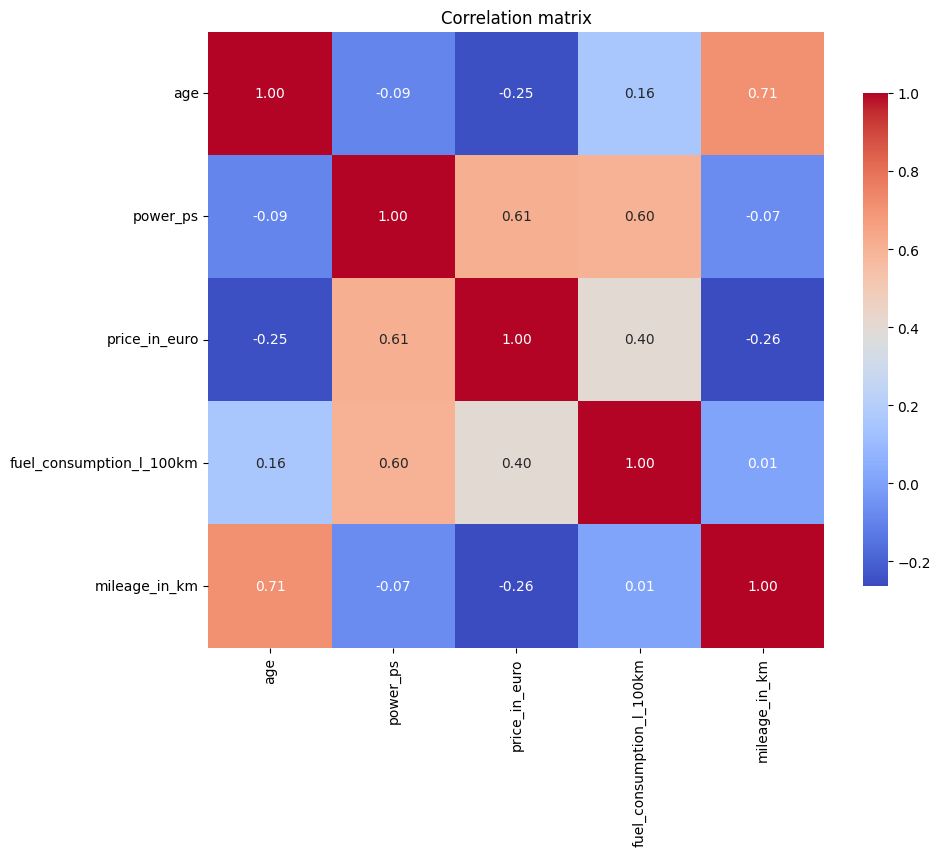

In [55]:
data_num = data[numeric_cols]
knn_imputer = KNNImputer(n_neighbors=5)
filled_data_knn = knn_imputer.fit_transform(data_num)
filled_data = pd.DataFrame(filled_data_knn, columns=numeric_cols)
correlation_matrix = filled_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation matrix')
plt.show()

In [56]:

result_data = data
result_data.reset_index(drop=True, inplace=True)
filled_data.reset_index(drop=True, inplace=True)
result_data['fuel_consumption_l_100km'] = filled_data['fuel_consumption_l_100km']

In [57]:
print(len(result_data), len(filled_data))
result_data.isnull().sum()

99752 99752


brand                       0
model                       0
color                       0
price_in_euro               0
power_ps                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
mileage_in_km               0
age                         0
dtype: int64

## 1.6 Detecting and removing outliers

Calculating outlier bounds

In [58]:
def get_outlier_bounds(data,col,q_low,q_up):
    Q1=data[col].quantile(q_low)
    Q3=data[col].quantile(q_up)
    iqr=Q3-Q1
    up_limit=Q3+1.5*iqr
    low_limit=Q1-1.5*iqr
    return low_limit,up_limit

In [59]:
def get_outliers_percent(data, col, q_low, q_up):
    low, up = get_outlier_bounds(data, col,q_low, q_up)
    outliers = [elem for elem in data[col] if (elem > up) or (elem < low)]
    return len(outliers) / data[col].shape[0] * 100

In [60]:
def rewrite_outliers(data,col, q_low, q_up):
    low,up=get_outlier_bounds(data,col, q_low, q_up)
    data.loc[(data[col]<low),col]=low
    data.loc[(data[col]>up),col]=up
    return data

def remove_outliers(data,col, q_low, q_up):
    low,up=get_outlier_bounds(data,col, q_low, q_up)
    data = data[(data[col] <= up) & (data[col] >= low)]
    return data

In [61]:
for col in numeric_cols:
    if col == 'price_in_euro':
        # detect outliers and remove them not to deform goal values
        print(col," | outliers percent - ",get_outliers_percent(result_data, col, 0.0, 0.85))
        result_data = remove_outliers(result_data, col,  0.0, 0.85)
    else:
        print(col," | outliers percent - ",get_outliers_percent(result_data, col, 0.25, 0.75))
        result_data = rewrite_outliers(result_data, col, 0.25, 0.75)

age  | outliers percent -  3.352313738070414
power_ps  | outliers percent -  7.639947068730452
price_in_euro  | outliers percent -  2.4981955249017562
fuel_consumption_l_100km  | outliers percent -  5.344437589965042
mileage_in_km  | outliers percent -  1.8764137363767222


In [62]:
result_data.describe()

price_in_euro      power_ps  fuel_consumption_l_100km  mileage_in_km  \
count   97260.000000  97260.000000              97260.000000   97260.000000   
mean    24186.917787    176.534619                  6.060209   86236.017401   
std     17091.468718     79.061144                  1.529172   72323.003618   
min       150.000000      1.000000                  2.150000       0.000000   
25%     12700.000000    120.000000                  5.000000   27700.000000   
50%     19990.000000    150.000000                  5.800000   70000.000000   
75%     30980.000000    204.000000                  6.900000  129433.750000   
max    106000.000000    365.000000                  9.750000  282034.375000   

                age  
count  97260.000000  
mean       8.542834  
std        4.887716  
min        2.000000  
25%        5.000000  
50%        7.000000  
75%       11.000000  
max       20.000000

# Step 2. Visualizing data

## 2.1 Visualising prices distribution

In [63]:
def create_hystogram (data, numeric_col, main_title, x_title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[numeric_col], bins=100, kde=True, stat='probability')
    plt.title(main_title)
    plt.xlabel(x_title)
    plt.ylabel('Frequency')
    plt.show()

def create_set_hystogram(data, cols):
    data[cols].hist(bins=20,figsize=(12,10))
    plt.tight_layout()
    plt.show()

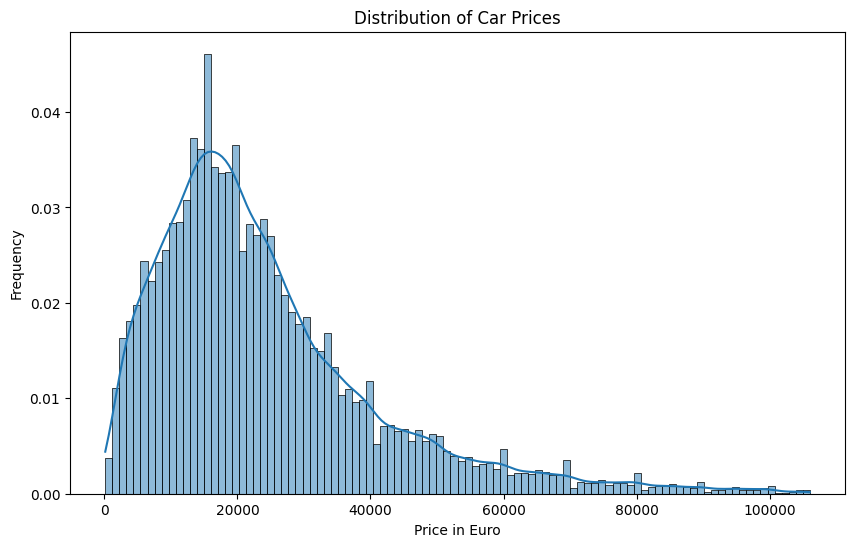

In [64]:
create_hystogram(result_data, 'price_in_euro', 'Distribution of Car Prices', 'Price in Euro')

## 2.2 Visualising all numeric data distribution

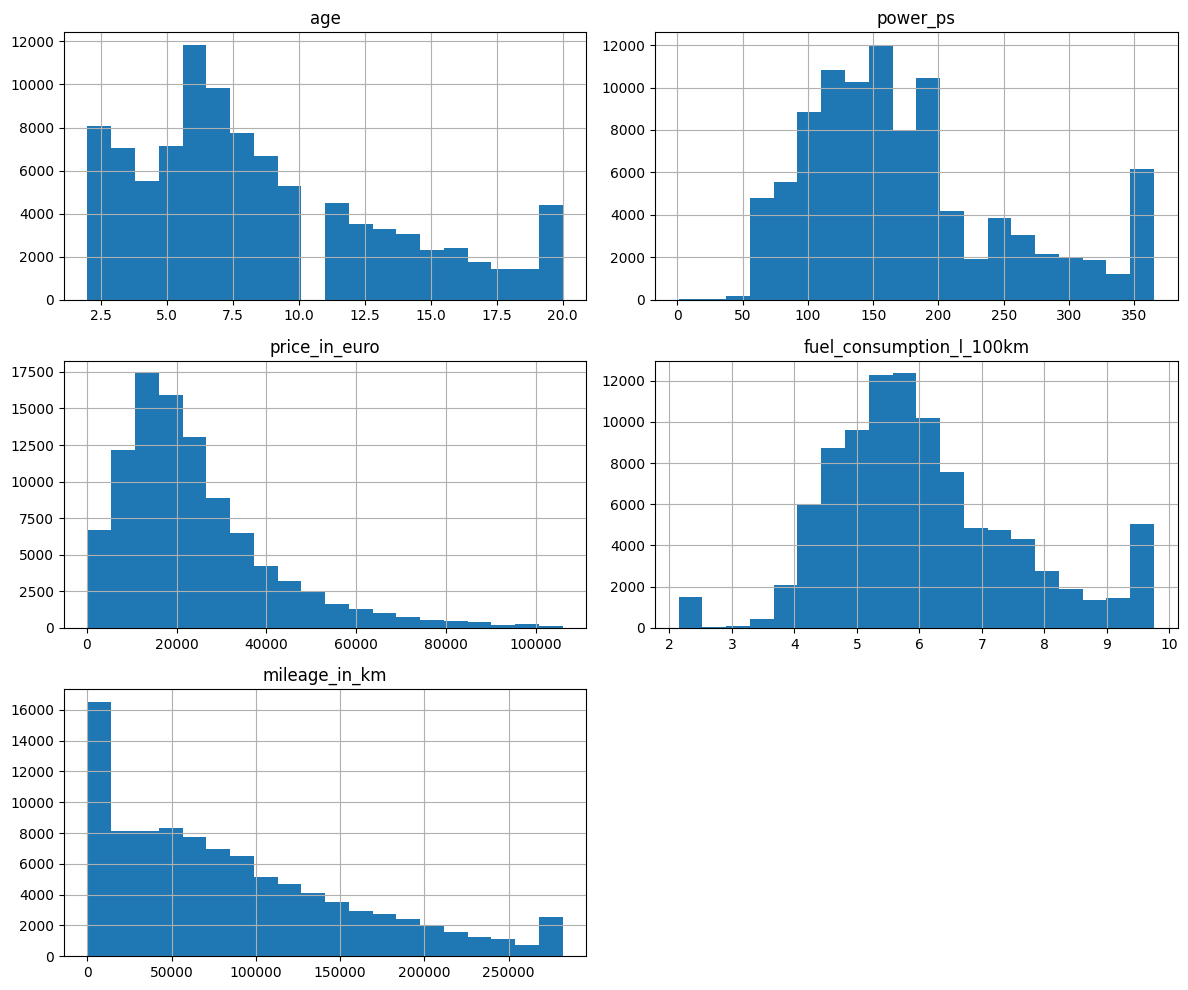

In [65]:
create_set_hystogram(result_data, numeric_cols)

## 2.3 Visualising categorical clolumns

In [68]:
categorical_cols = [
'brand',                      
'model',                    
'color',                                      
'transmission_type',         
'fuel_type'
]

In [66]:
def create_categorical_diagram(data, col):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=col, palette='pastel')
    plt.title('Количество по категориям')
    plt.xlabel('Категория')
    plt.ylabel('Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

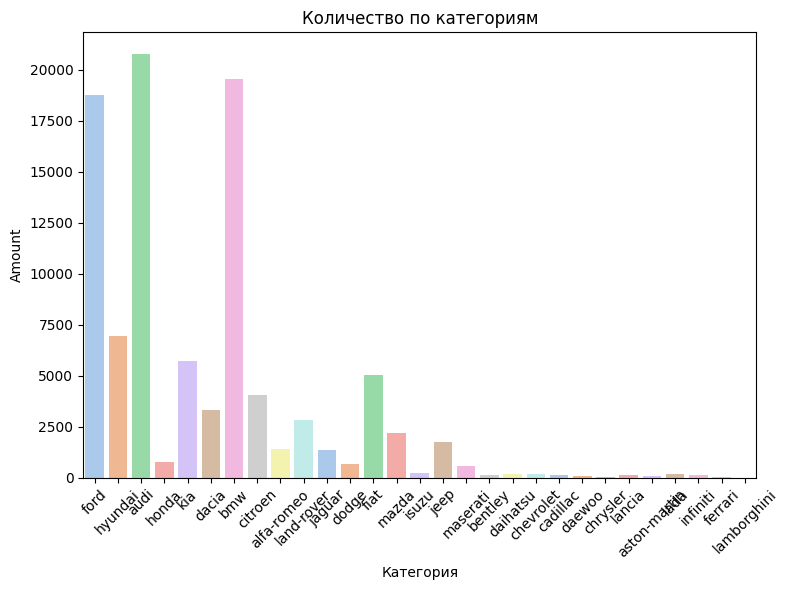

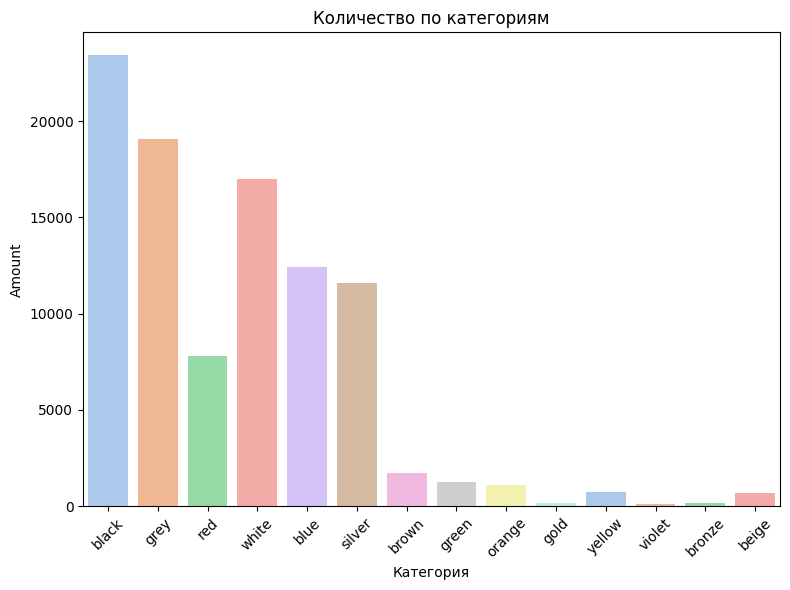

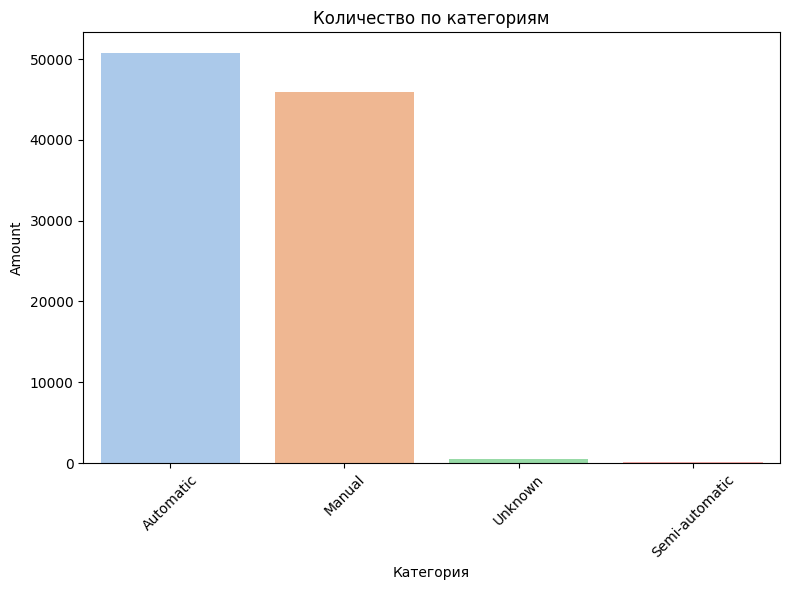

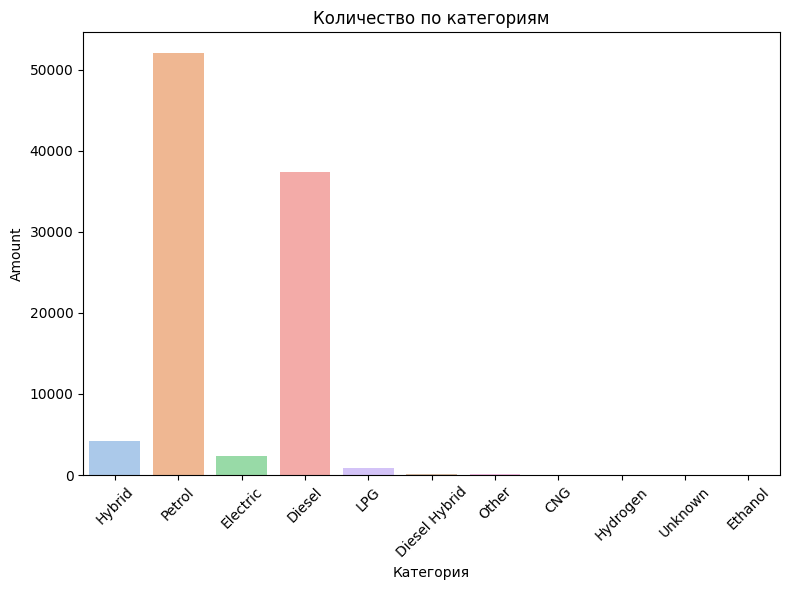

In [69]:
for col in categorical_cols:
    if col != 'model':
        create_categorical_diagram(result_data, col)

## 2.4 Visualising average price for categorical parameters

In [70]:
def categorical_price_plot(data, col):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=col, y='price_in_euro', data=data, palette='viridis')
    plt.title('Average Car Prices by categorical column')
    plt.xlabel(col)
    plt.ylabel('Average Price in Euro')
    plt.xticks(rotation=45)  # Поворот меток по оси X для удобства чтения
    plt.show()

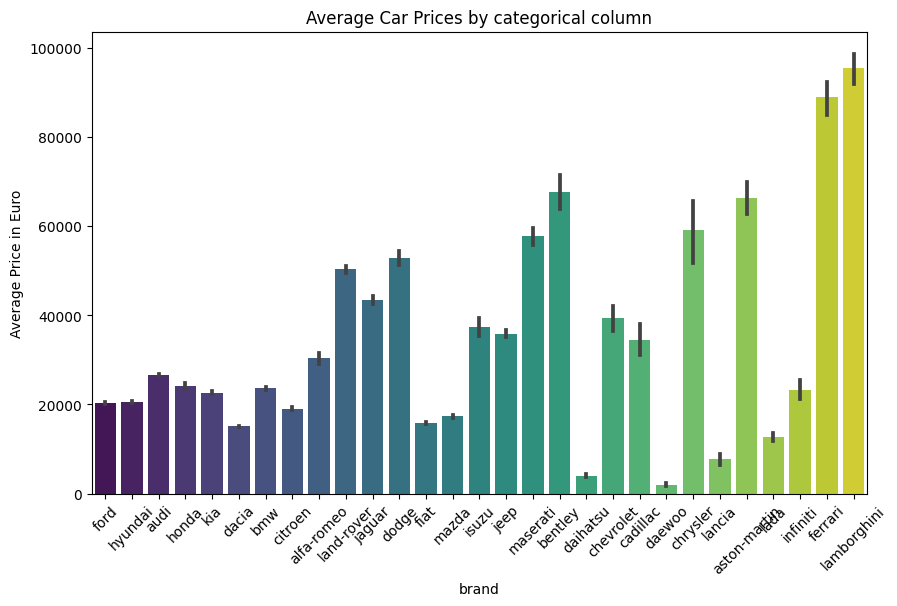

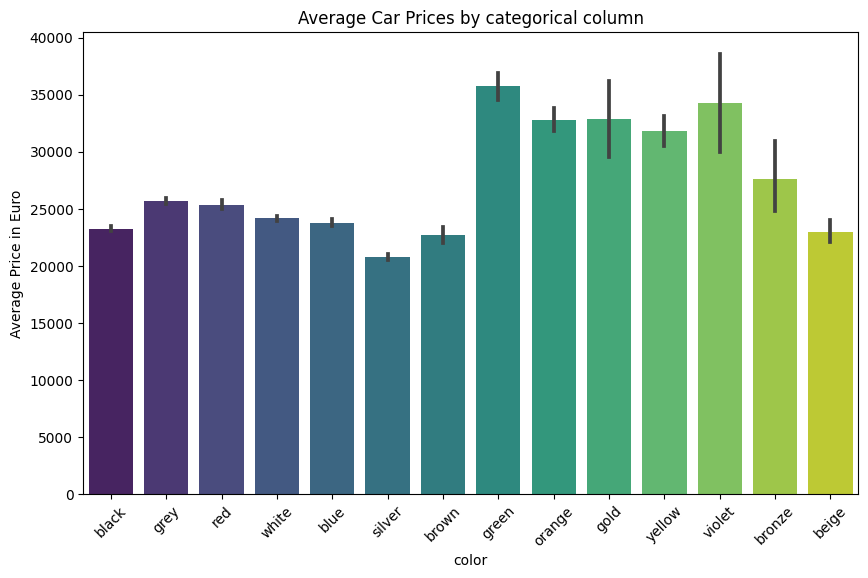

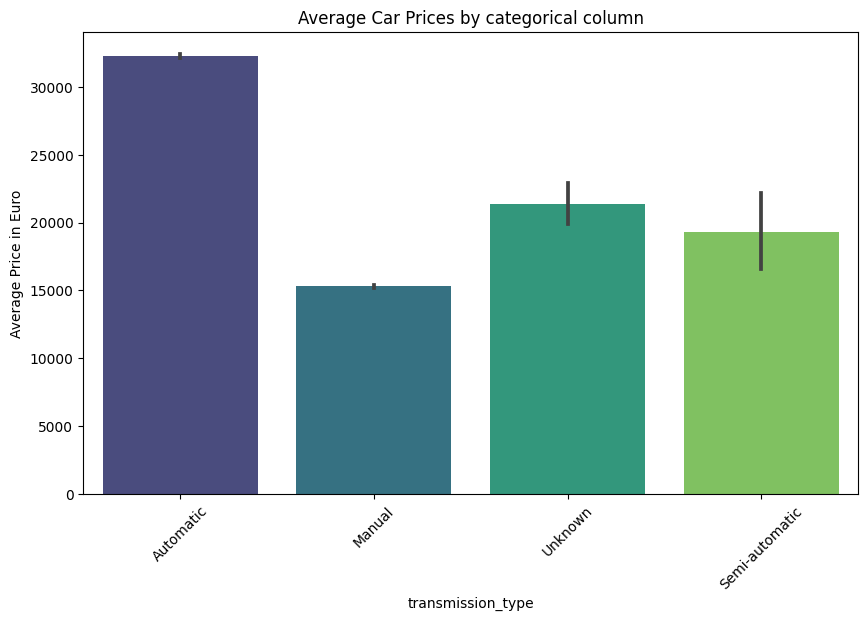

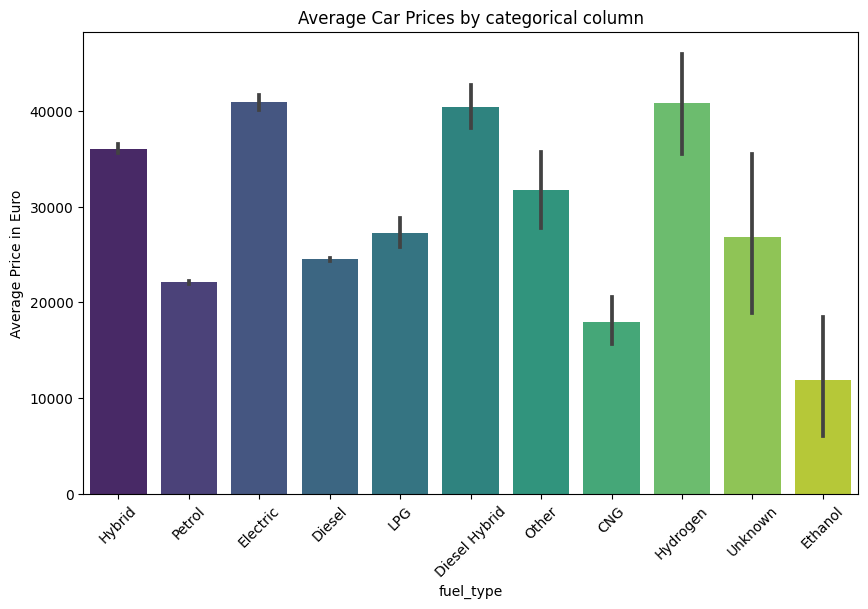

In [71]:
for col in categorical_cols:
    if col != 'model':
        categorical_price_plot(result_data, col)

# Step 3. Encoding categorical values and split data

In [72]:
def encode_categorical(data, cols): 
    encoder = ce.BinaryEncoder(cols=cols)
    data_encoded = encoder.fit_transform(data)
    return data_encoded

In [73]:
raw_data = result_data
result_data = encode_categorical(result_data, categorical_cols)

In [74]:
x=result_data.drop('price_in_euro',axis=1)
y=result_data['price_in_euro']
r_x=raw_data.drop('price_in_euro',axis=1)
r_y=raw_data['price_in_euro']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=21)
rx_train,rx_test,ry_train,ry_test=train_test_split(r_x,r_y,test_size=0.2,random_state=21)

# Step 4. Predicting price

##  4.1 Standard ML models

In [3]:
R2={}
RMSE = {}
MAE = {}

In [76]:
# Getting some classic models for regression
model1 = LinearRegression()
model2 = DecisionTreeRegressor(random_state=42)
model3 = RandomForestRegressor(random_state=42)
model4 = GradientBoostingRegressor(random_state=42)
model5 = LinearRegression()
model6 = CatBoostRegressor(iterations=100, depth=16, learning_rate=0.1,cat_features = categorical_cols, verbose=0, random_state=42)

models = {
    'LinearRegression': model1,
    'DecisionTreeRegressor': model2,
    'RandomForestRegressor': model3,
    'GradientBoostingRegressor': model4,
    'PolynomicalRegression' : model5,
    'CatBoost' : model6
}

In [10]:
def save_metrics_to_csv(name, r2, rmse, mae, filename='metrics.csv'):
    metrics_df = pd.DataFrame([{
        'Model': name,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    }])
    
    if os.path.exists(filename):
        metrics_df.to_csv(filename, mode='a', header=False, index=False)
    else:
        metrics_df.to_csv(filename, index=False)

In [4]:
def train_model_standard(model, x_train, y_train, name):
    # model training
    if name == 'PolynomicalRegression':
        poly = PolynomialFeatures(degree=2)  # Указываем степень полинома
        x_train = poly.fit_transform(x_train)
    model.fit(x_train,y_train)

def predict(model, x_test, x_train, name):
    # values predicting
    if name == 'PolynomicalRegression':
        poly = PolynomialFeatures(degree=2)  # Указываем степень полинома
        x_train = poly.fit_transform(x_train)
        x_test = poly.transform(x_test)
    pre = model.predict(x_test)
    return pre

def calculate_metrics(model, x_test, y_test, pre, name, sequential = False, filename='metrics.csv'):
    # Metrics calculation
    acc = r2_score(y_test, pre)
    rmse = np.sqrt(mean_squared_error(y_test, pre))
    mae = mean_absolute_error(y_test, pre)
    
    R2[name] = acc
    RMSE[name] = rmse
    MAE[name] = mae

    # Output for model
    print(f'Model: {name}')
    print(f'R²: {acc}, RMSE: {rmse}, MAE: {mae}')
    save_metrics_to_csv(name, acc, rmse, mae, filename)

    # Visualizations with plots
    plt.figure(figsize=(12, 6))

    # Actual vs Predicted values
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, pre)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')

    # Residuals diagram
    plt.subplot(1, 2, 2)
    sns.histplot(y_test - pre, bins=30, kde=True)
    plt.xlabel('Residuals')
    plt.title('Distribution of Residuals')
    plt.tight_layout()
    plt.show()

Model: LinearRegression
R²: 0.7704158838751328, RMSE: 8171.279718084696, MAE: 5449.411166817445


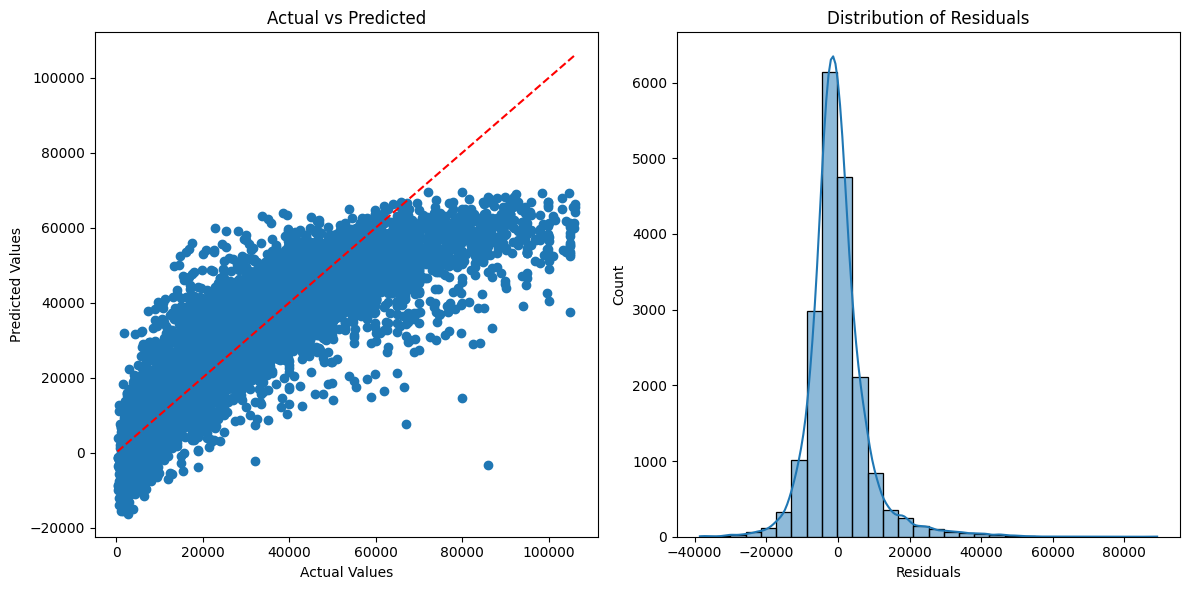

Model: DecisionTreeRegressor
R²: 0.8136417775504083, RMSE: 7361.959741045846, MAE: 4034.1190073036114


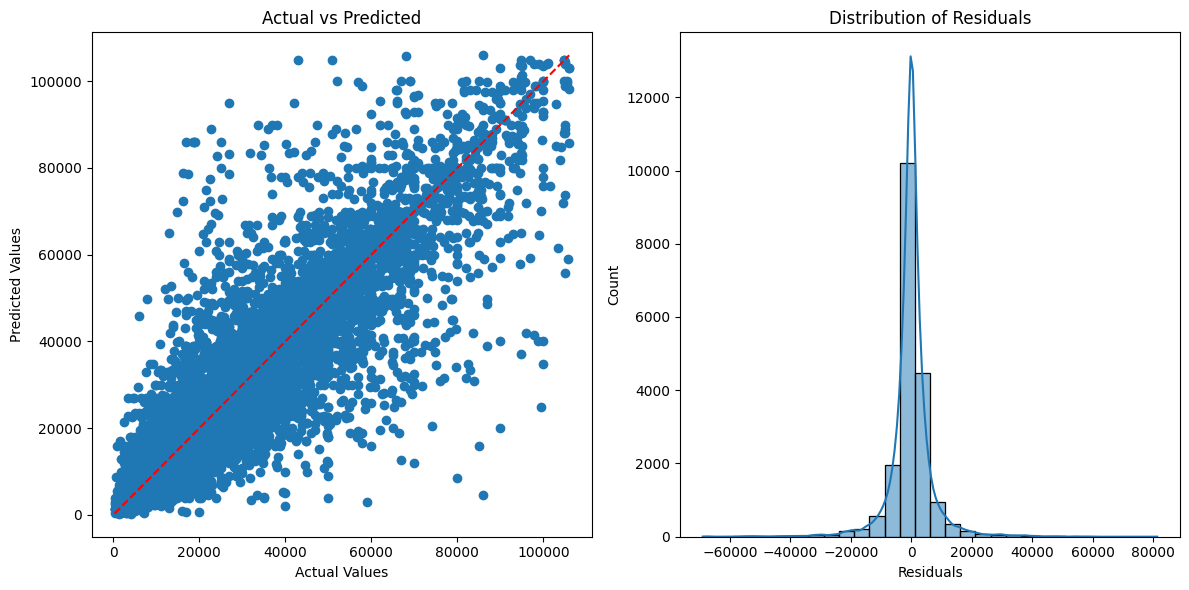

Model: RandomForestRegressor
R²: 0.9047443344443595, RMSE: 5263.378067169899, MAE: 2937.7874214396334


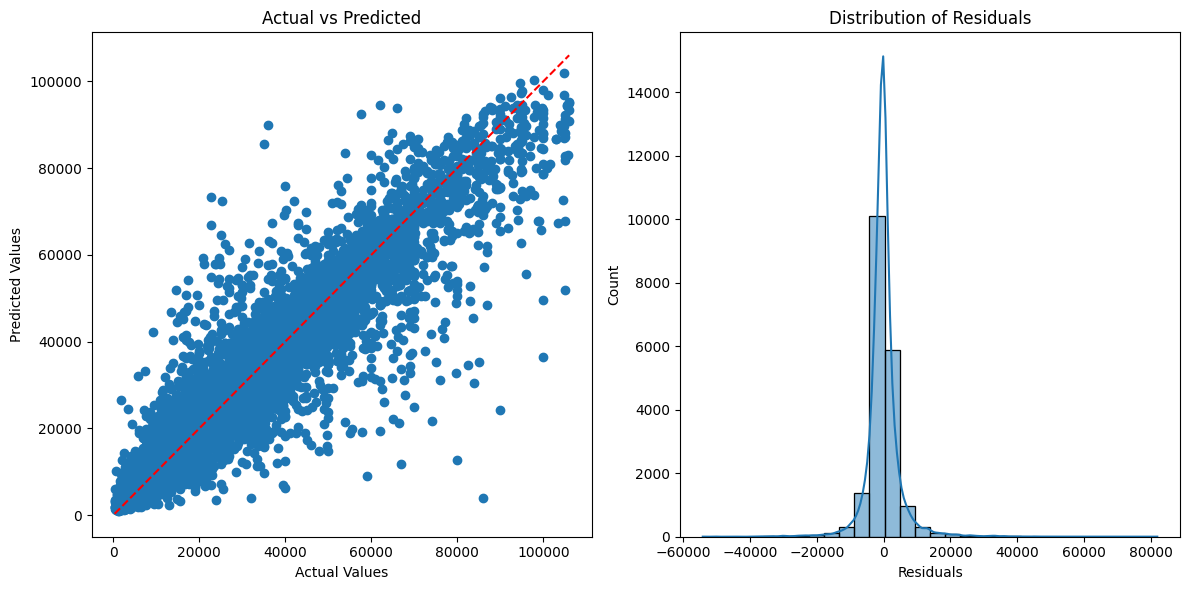

Model: GradientBoostingRegressor
R²: 0.8616935557633699, RMSE: 6342.206326706241, MAE: 3862.263950732732


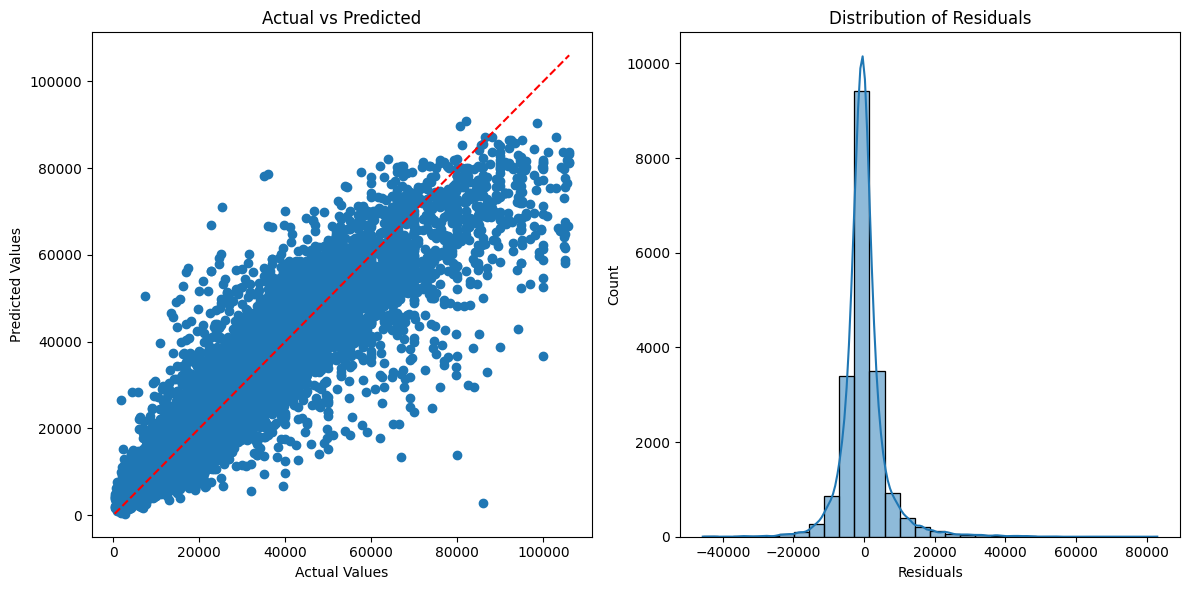

Model: PolynomicalRegression
R²: 0.8684684876470445, RMSE: 6184.91969808835, MAE: 3851.1250014997


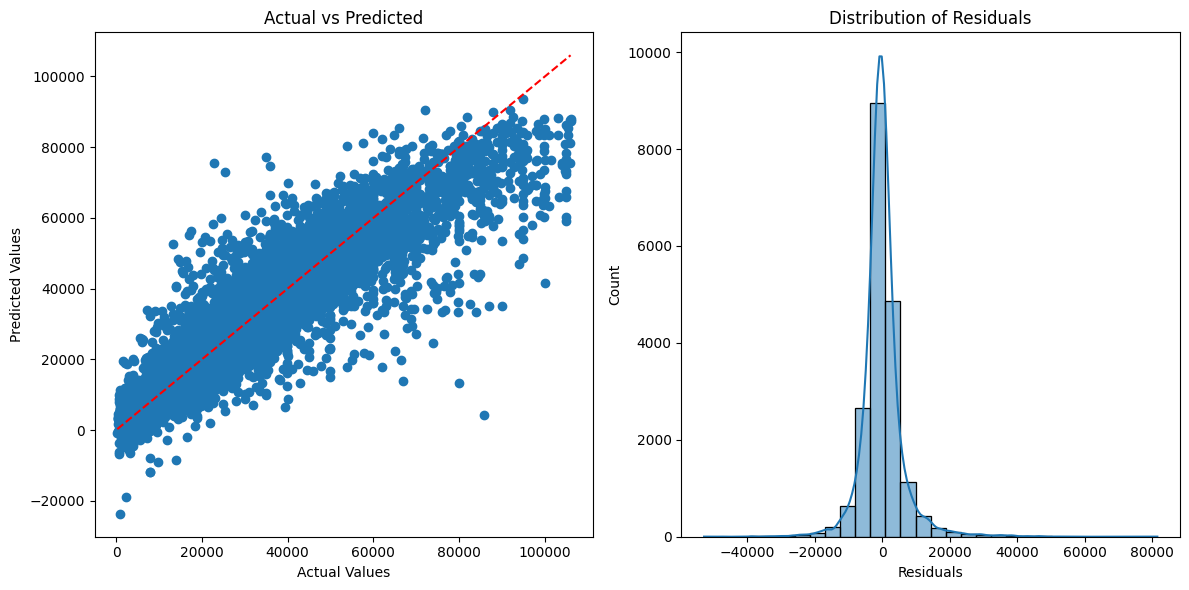

Model: CatBoost
R²: 0.9044849642327906, RMSE: 5270.538982177807, MAE: 3002.6049636777943


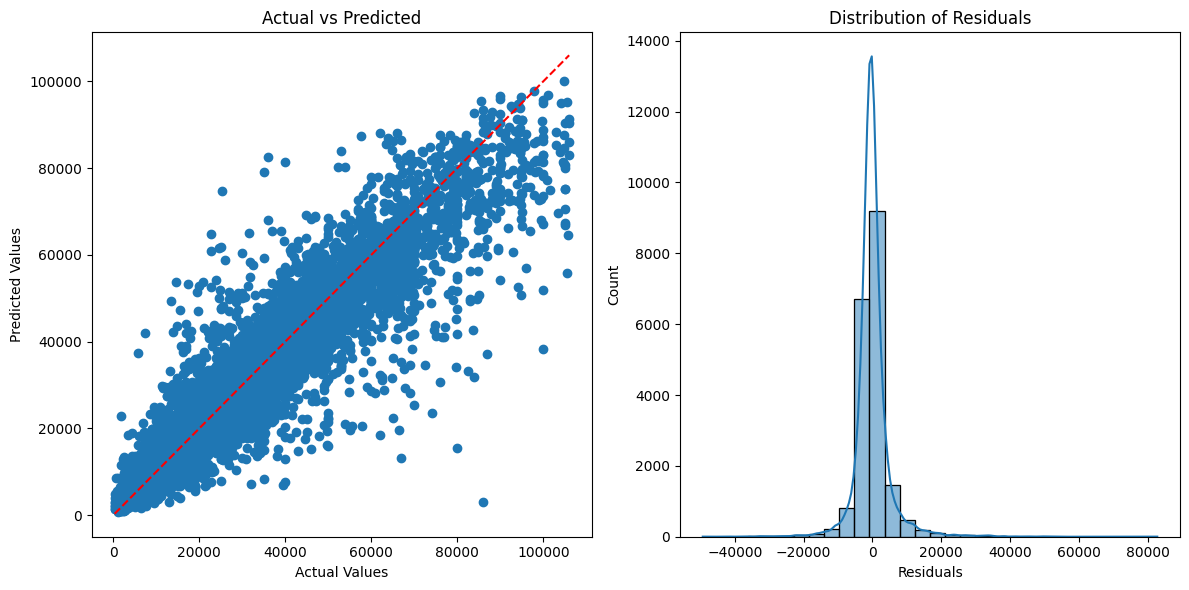

In [79]:
for name, model in models.items():
    if name == 'CatBoost':
        train_model_standard(model, rx_train, ry_train, name)
        pre = predict(model, rx_test, rx_train, name)
        calculate_metrics(model, rx_test, ry_test, pre, name)
    else:
        train_model_standard(model, x_train, y_train, name)
        pre = predict(model, x_test, x_train, name)
        calculate_metrics(model, x_test, y_test, pre, name)

## 4.2 Prediction with DL. Own neural network

In [80]:
# Scaling values for neural network
def scale_x_values(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [5]:
# Saving train and test preprocessed datasets
def save_datasets(X_train, X_test, y_train, y_test, filename_prefix):
    joblib.dump(X_train, f'{filename_prefix}_X_train.pkl')
    joblib.dump(X_test, f'{filename_prefix}_X_test.pkl')
    joblib.dump(y_train, f'{filename_prefix}_y_train.pkl')
    joblib.dump(y_test, f'{filename_prefix}_y_test.pkl')

# Load datasets from disk
def load_datasets(filename_prefix):
    X_train = joblib.load(f'{filename_prefix}_X_train.pkl')
    X_test = joblib.load(f'{filename_prefix}_X_test.pkl')
    y_train = joblib.load(f'{filename_prefix}_y_train.pkl')
    y_test = joblib.load(f'{filename_prefix}_y_test.pkl')
    return X_train, X_test, y_train, y_test


In [ ]:
x_pr_train, x_pr_test = scale_x_values(x_train, x_test)
save_datasets(x_pr_train, x_pr_test, y_train, y_test, "preprocessed_data")


In [81]:
# Model with architecture, that represented the best results
def create_dl_model(X_train_cols):
    model = Sequential([
        Dense(512, activation='relu',  input_shape=(X_train_cols,)),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    return model

In [6]:
# training
def train_model(model, X_train, X_test, y_train, y_test, model_name):
    # splitting data to train and validation parts for best performance
    X_train,X_val,Y_train,Y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=21)
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # Define callbacks
    es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.09, patience=15, min_lr=1e-6)
    
    history = model.fit(X_train, Y_train, epochs=200, batch_size=128, validation_data=(X_val, Y_val), callbacks=[es, lr], verbose=0)
    model.save(f'models/{model_name}.h5')
    return history

def predict_dl(model, x_test):
    pre = model.predict(x_test).flatten()
    return pre

In [83]:
def view_loss_plot(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')  
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

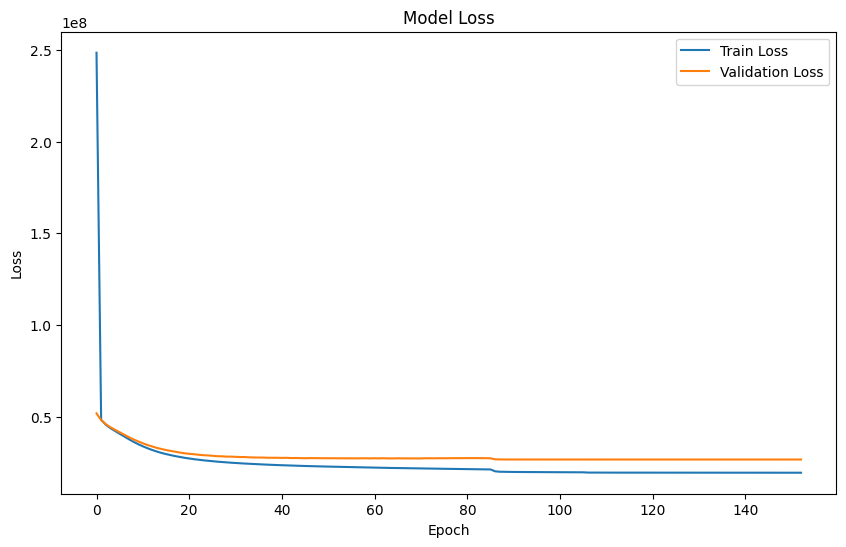

In [85]:
# Creating my model
my_model = create_dl_model(x_train.shape[1])
# Training
x_train, x_test, y_train, y_test = load_datasets("/kaggle/input/processed-data/preprocessed_data")
hist = train_model(my_model, x_train, x_test, y_train, y_test, 'DL Base Model')
# View train info about loss
view_loss_plot(hist)

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: DL Base Model
R²: 0.9112800156312459, RMSE: 5079.604354416003, MAE: 2882.580075963103


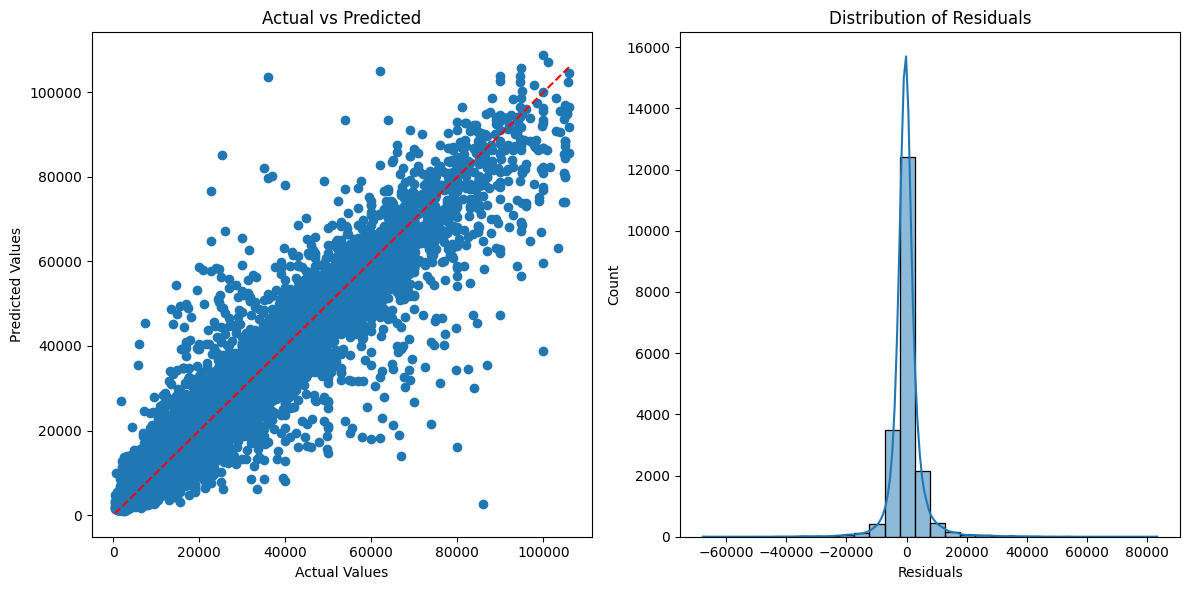

In [88]:
# calculating metrics for test data prediction
my_model = load_model('/kaggle/input/base-model/keras/default/1/DL Base Model.h5')
pre = predict_dl(my_model, x_test)
calculate_metrics(my_model, x_test, y_test, pre, 'DL Base Model', True)

## 4.3 Compare metrics with standard methods

In [89]:
def make_metric_plot(metric_data, name):
    names = list(metric_data.keys())
    values = list(metric_data.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(names, values, color='skyblue')
    plt.title(name)
    plt.xlabel('Models')
    plt.ylabel(name)
    plt.xticks(rotation=45)
    bars = plt.bar(names, values, color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')
    plt.show()

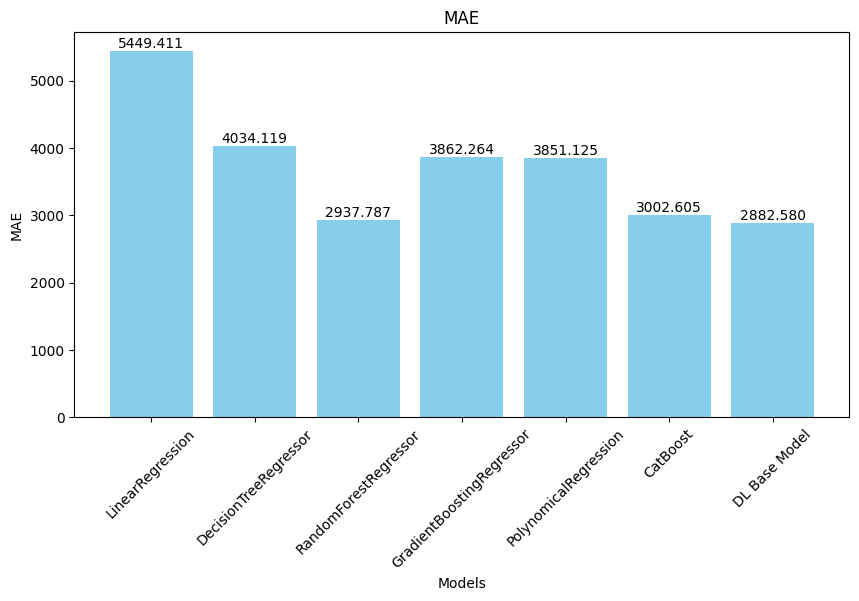

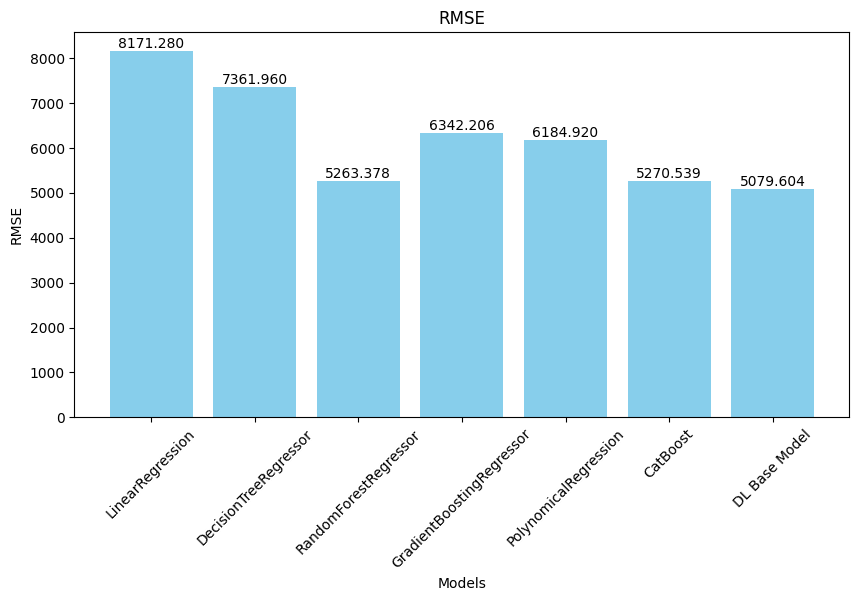

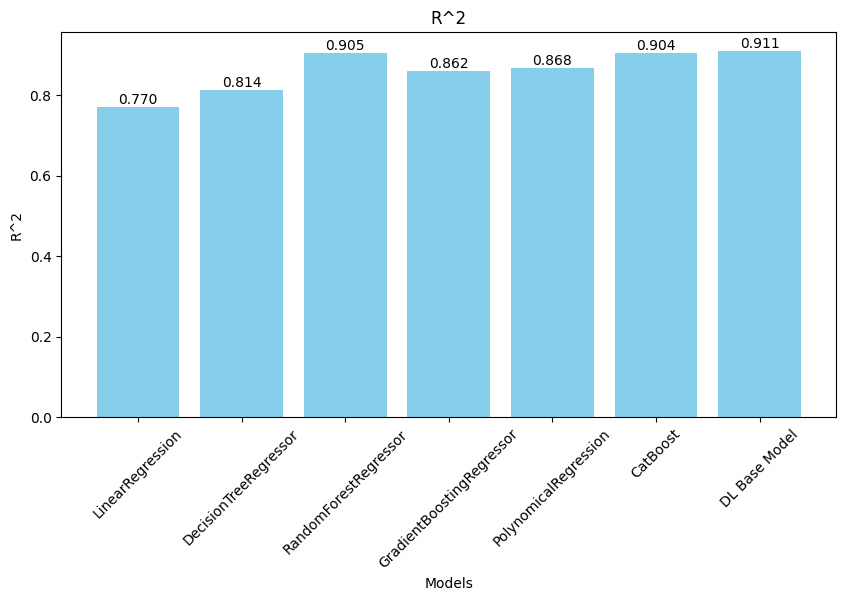

In [90]:
make_metric_plot(MAE, 'MAE')
make_metric_plot(RMSE, 'RMSE')
make_metric_plot(R2, 'R^2')

As seen, DL Regression performs slightly better than Random Forest Regression and CatBoost Regression. This indicates that DL models can be  as effective as standard ones for prediction, making them a suitable choice for this task. 

# PART 2
The initial architecture was manually selected based on a limited number of heuristic trials and demonstrated competitive performance compared to traditional regression models.

In this section, we proceed to conduct a comprehensive analysis of architectural and validation strategies in the context of deep neural networks for regression. Our goal is to determine the most effective configuration of the model by:

systematically modifying the network architecture (depth, width, activation functions),

tuning hyperparameters using automated methods.

This multi-phase exploration is designed to provide a more rigorous and data-driven foundation for the final model selection, compared to the previously heuristic-based design.

In [7]:
x_train, x_test, y_train, y_test = load_datasets("/kaggle/input/processed-data/preprocessed_data")

In [ ]:
def create_dynamic_model(X_train_cols, layer_sizes):
    model = Sequential()
    model.add(Dense(layer_sizes[0], activation='relu', input_shape=(X_train_cols,)))
    for units in layer_sizes[1:]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1))
    return model


## 1. Architecture experiments

### 1.1 Depth experiments
H₀ (null hypothesis): Changing the depth of a neural network, while maintaining a consistent tapered (narrowing) layer structure, does not have a statistically significant effect on the model’s prediction performance.

H₁ (alternative hypothesis): The depth of a neural network influences the final model performance: increasing the number of layers in a tapered architecture can lead to a reduction in prediction error up to a certain point, after which the effect may plateau or lead to overfitting.

In [ ]:
architectures = {
    'model_depth2': [256],
    'model_depth3': [512, 128],
    'model_depth4': [512, 128, 32],
    'model_depth5': [512, 128, 32, 8],
    'model_depth6': [1024, 512, 128, 32, 8],
    'model_depth7': [2048, 1024, 512, 128, 32, 8]
}

for name, layers in architectures.items():
    print(f"WORKING WITH MODEL {name}")
    model = create_dynamic_model(x_train.shape[1], layers)
    hist = train_model(model, x_train, x_test, y_train, y_test, f'{name}')
    view_loss_plot(hist)
    pre = predict_dl(model, x_test)
    calculate_metrics(model, x_test, y_test, pre, f'{name}', 'metrics_depth.csv') 

In [30]:
def make_metric_plots_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    
    metrics = ['MAE', 'R2', 'RMSE']
    
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        bars = plt.bar(df['Model'], df[metric], color='skyblue')
        plt.title(metric)
        plt.xlabel('Models')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', 
                    ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

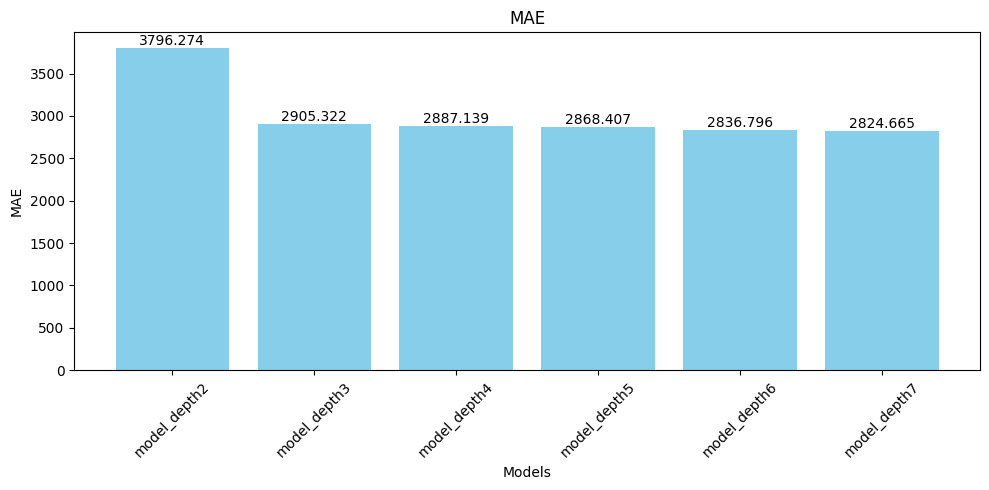

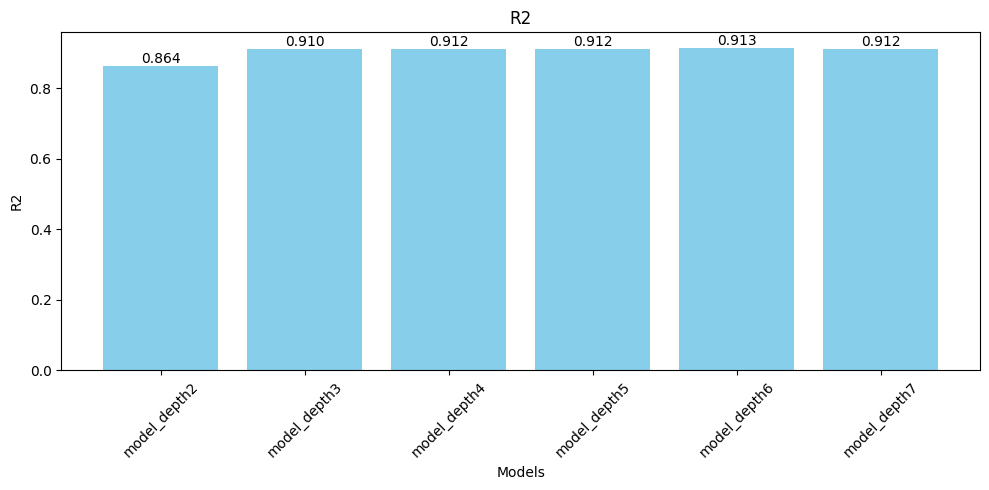

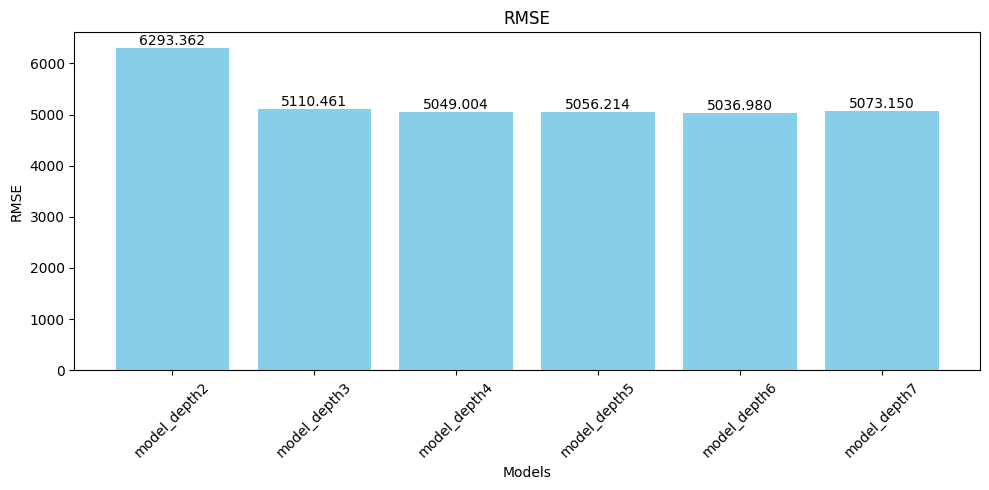

In [32]:
make_metric_plots_from_csv('/kaggle/input/metrics-depth/metrics_depth.csv')

In [23]:
def plot_metrics_vs_depth(csv_path):
    df = pd.read_csv(csv_path)
    df["Depth"] = df["Model"].str.extract(r"(\d+)").astype(int)
    df = df.sort_values("Depth")

    metrics = ['R2', 'RMSE', 'MAE']
    colors = ['green', 'red', 'blue']

    for metric, color in zip(metrics, colors):
        plt.figure(figsize=(8, 5))
        plt.plot(df["Depth"], df[metric], marker='o', color=color, label=metric)
        plt.title(f'{metric} vs. Network Depth')
        plt.xlabel('Number of Layers (Depth)')
        plt.ylabel(metric)
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

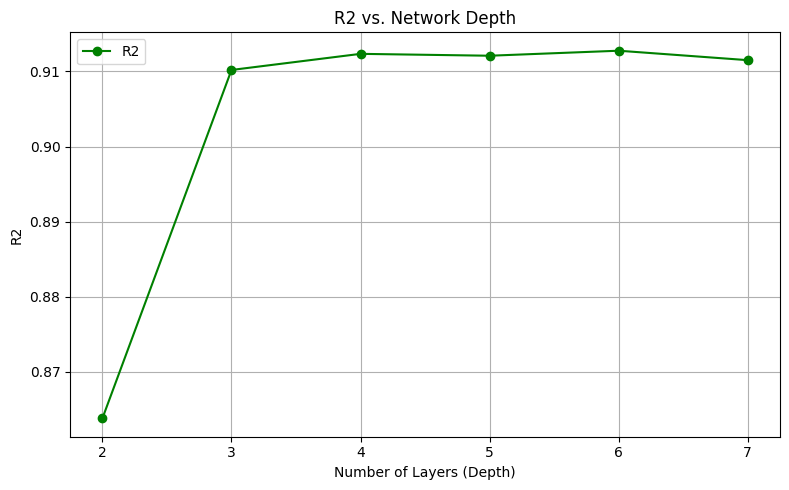

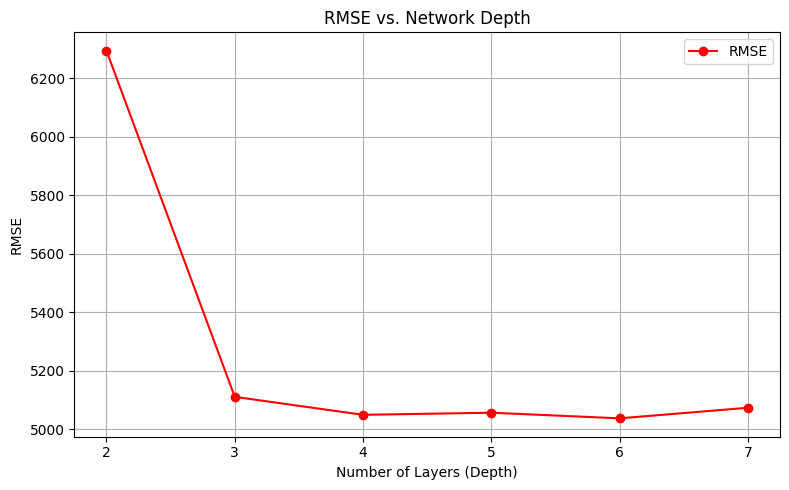

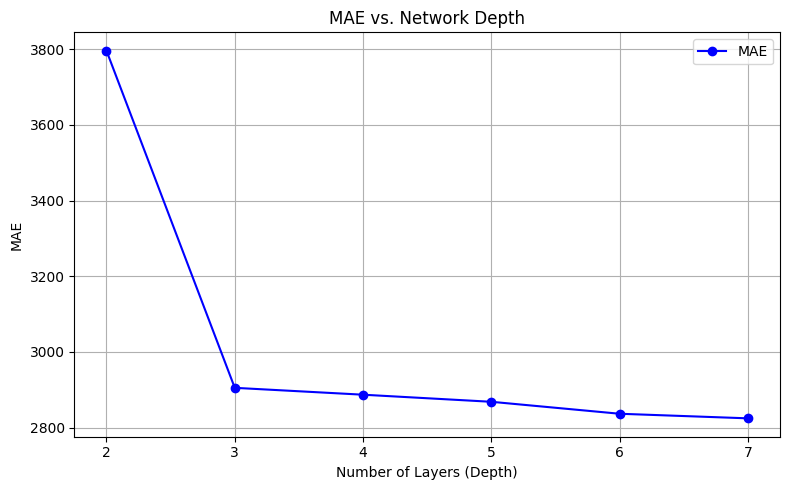

In [24]:
plot_metrics_vs_depth('/kaggle/input/metrics-depth/metrics_depth.csv')

**Clear trend:** increasing the depth of the neural network from 2 to 4 layers significantly improves model performance, as shown by rising R² and decreasing RMSE and MAE. However, from depth 5 to 6, the improvements become marginal, suggesting that the model reaches a saturation point where deeper architectures yield diminishing returns. At depth 7, performance slightly declines, hinting at the onset of overfitting or architectural inefficiency.

**Hypothesis H₁ is supported:** network depth positively influences performance up to a certain limit, after which the benefits plateau or even reverse.

**Best params:** 5-6 layers

### 1.2 Width experiments

Null Hypothesis (H₀):
Increasing the number of neurons per layer (while keeping the overall layer structure constant) does not significantly affect the predictive performance of the neural network.

Alternative Hypothesis (H₁):
Increasing the number of neurons per layer improves model performance up to a point by enhancing its representational capacity, leading to lower prediction error — particularly in architectures with gradual layer narrowing and appropriate regularization.

In [ ]:
architectures = {
    "model_width_low":     [64, 32, 16, 8],
    "model_width_medium":  [256, 64, 32, 8],
    "model_width_base":    [512, 128, 32, 8],
    "model_width_high":    [1024, 256, 64, 8],
    "model_width_extreme": [2048, 512, 128, 8],
    "model_width_ultra":   [4096, 1024, 256, 8]
}

for name, layers in architectures.items():
    print(f"WORKING WITH MODEL {name}")
    model = create_dynamic_model(x_train.shape[1], layers)
    hist = train_model(model, x_train, x_test, y_train, y_test, f'{name}')
    last_epoch = len(hist.history['loss'])
    print(f"Last epoch: {last_epoch}")
    view_loss_plot(hist)
    pre = predict_dl(model, x_test)
    calculate_metrics(model, x_test, y_test, pre, f'{name}', 'metrics_width.csv') 

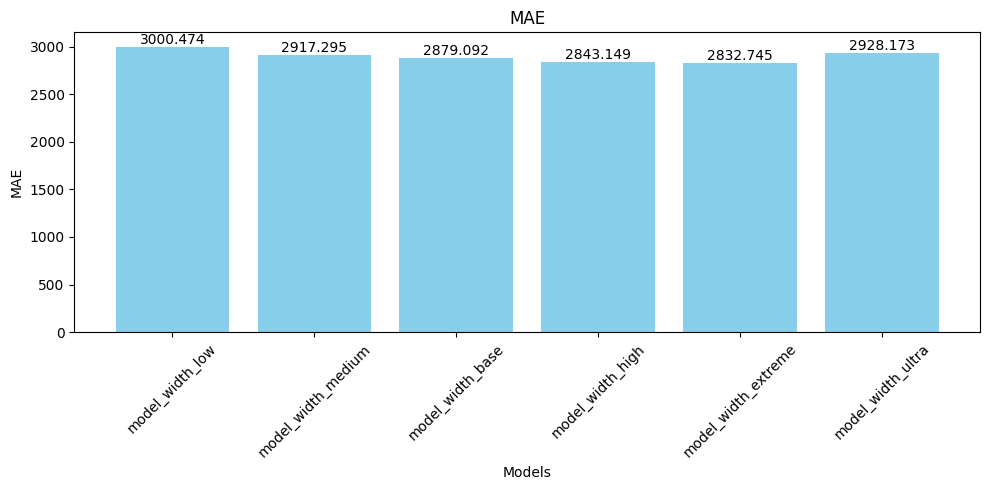

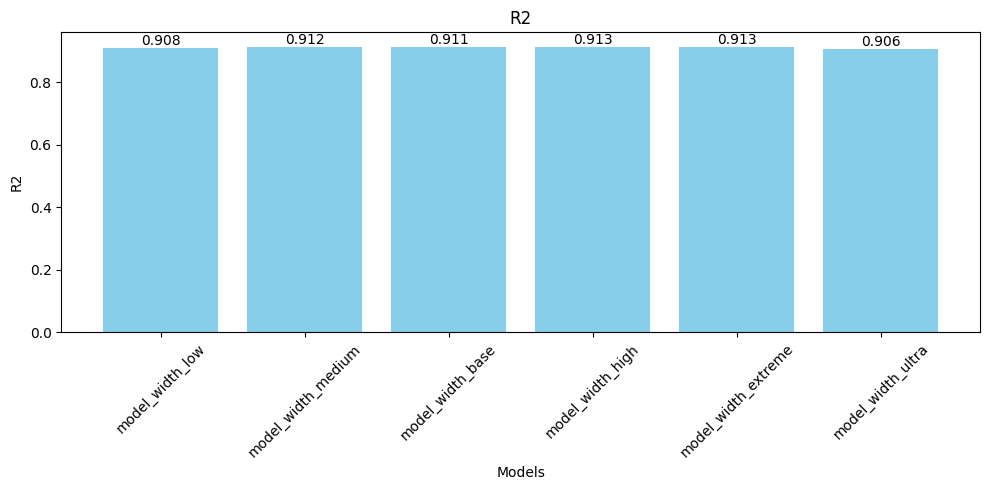

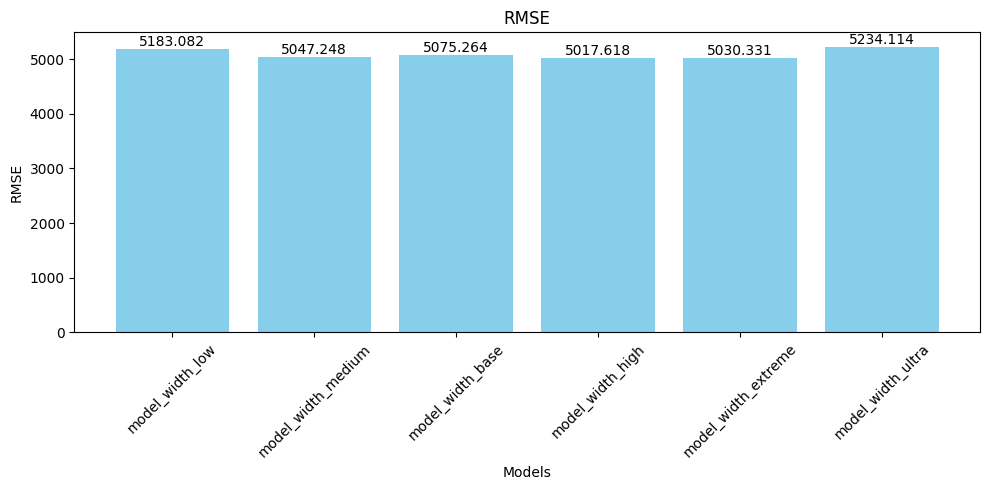

In [25]:
make_metric_plots_from_csv('/kaggle/input/metrics-width-1/metrics1_width.csv')

In [27]:
def plot_metrics(csv_path):
    df = pd.read_csv(csv_path)
    metrics = ['R2', 'RMSE', 'MAE']
    colors = ['green', 'red', 'blue']

    for metric, color in zip(metrics, colors):
        plt.figure(figsize=(8, 5))
        plt.plot(df["Model"], df[metric], marker='o', color=color, label=metric)
        plt.title(f'{metric}')
        plt.xlabel('Models by width')
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

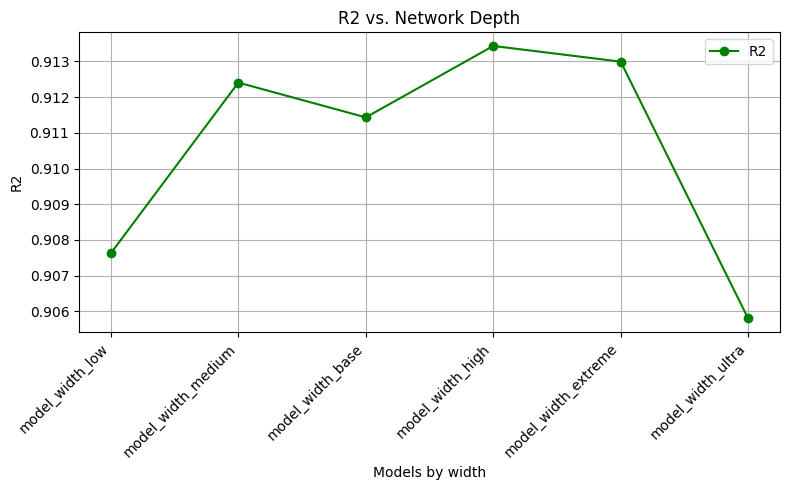

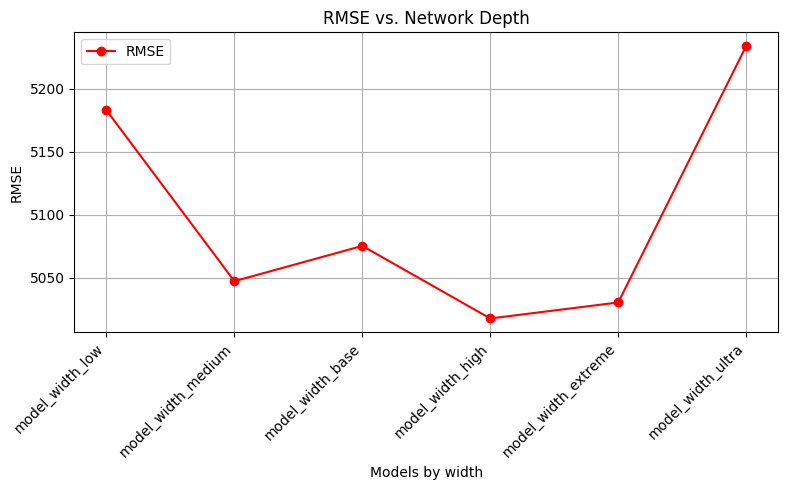

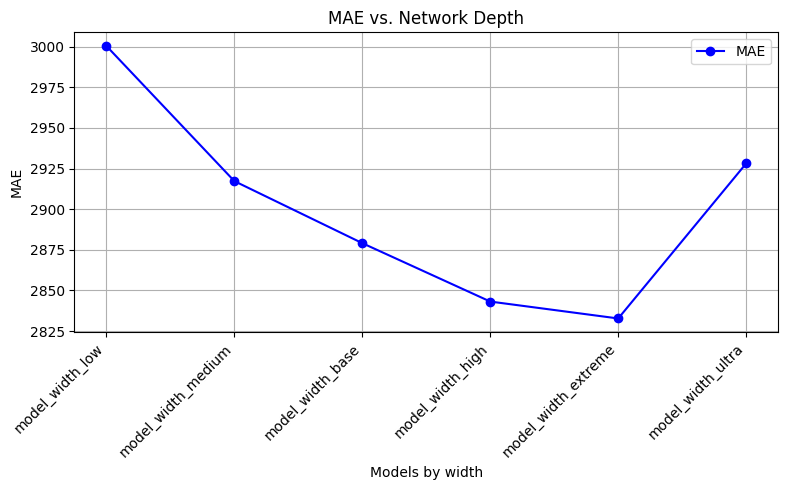

In [28]:
plot_metrics('/kaggle/input/metrics-width-1/metrics1_width.csv')

**Result:**
The results of the width variation experiment support the alternative hypothesis (H₁). Model performance improves from model_width_low to model_width_high, which achieves the best metrics

model_width_extreme is close but slightly less stable or effective — possibly due to diminishing returns or overcapacity.

model_width_ultra actually performs worse, likely due to overfitting or training inefficiency with too many parameters.

**Thus, the influence of layer width is evident, but it is nonlinear and limited: after a certain point, the effect begins to diminish or even turn negative.**

**The most effective:** model_width_high

### 1.3 Architectures pattern experiment

Null Hypothesis (H₀):
Changing the internal layer width pattern (shrinking, constant, expanding, etc.) has no statistically significant effect on the model's predictive performance, assuming total capacity is roughly similar.

Alternative Hypothesis (H₁):
The architecture pattern of a neural network — particularly whether it shrinks, expands, or fluctuates in width — significantly affects its predictive performance. Some patterns may enhance generalization and reduce error more effectively than others.

In [ ]:
architectures = {
    "model_pattern_shrinking":      [512, 128, 32, 8],
    "model_pattern_constant":       [128, 128, 128, 128],
    "model_pattern_expanding":      [32, 64, 128, 256],
    "model_pattern_bottleneck":     [512, 64, 512, 64],
    "model_pattern_zigzag":         [64, 256, 64, 256]
}

for name, layers in architectures.items():
    print(f"WORKING WITH MODEL {name}")
    model = create_dynamic_model(x_train.shape[1], layers)
    hist = train_model(model, x_train, x_test, y_train, y_test, f'{name}')
    last_epoch = len(hist.history['loss'])
    print(f"Last epoch: {last_epoch}")
    view_loss_plot(hist)
    pre = predict_dl(model, x_test)
    calculate_metrics(model, x_test, y_test, pre, f'{name}', 'metrics_pattern.csv') 

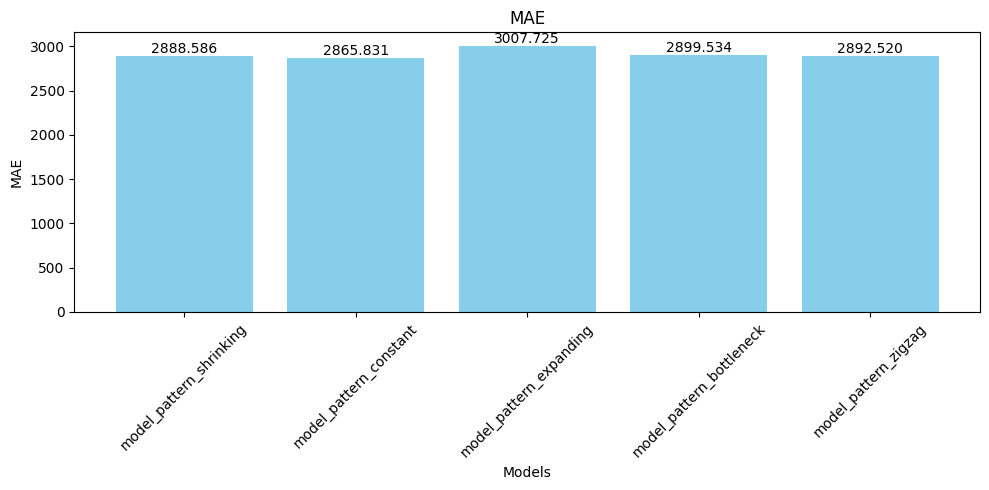

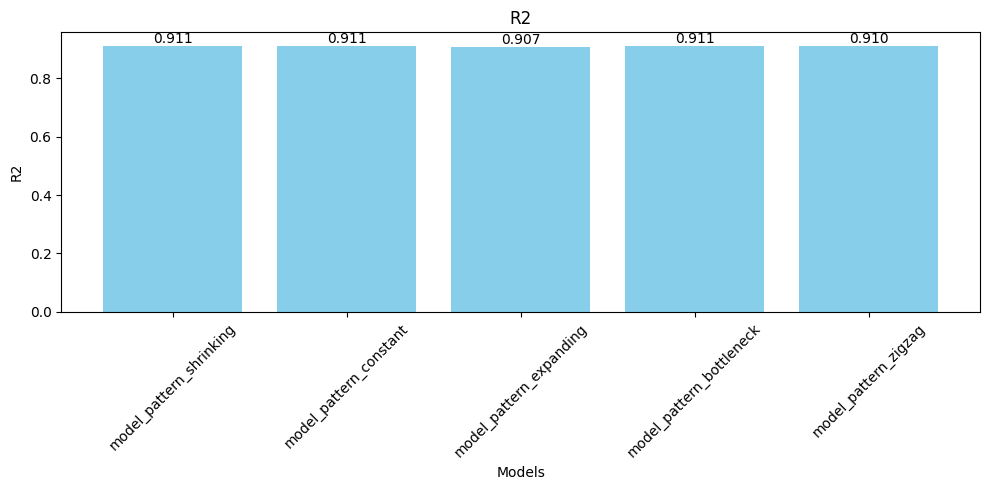

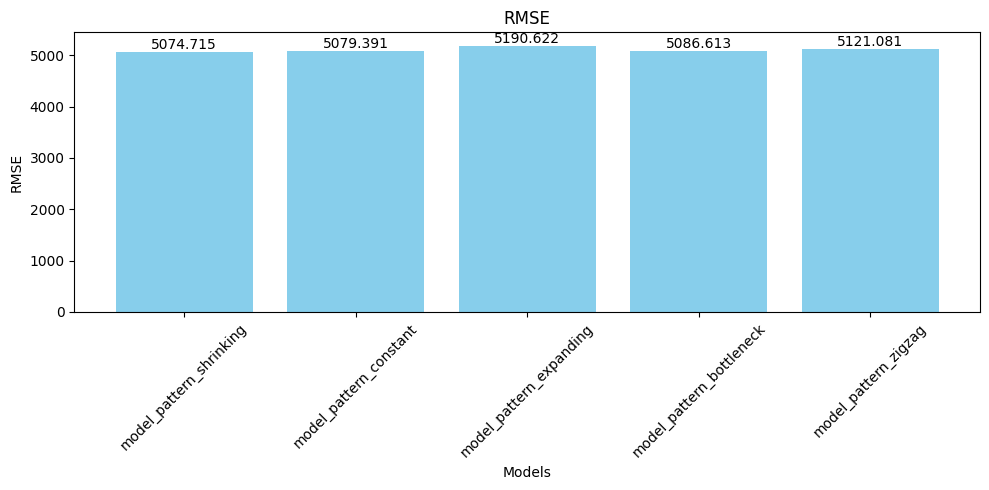

In [31]:
make_metric_plots_from_csv('/kaggle/input/metrics-pattern/metrics1_pattern.csv')

**Results:**
Changing the architecture pattern **does affect** model performance, but the differences are not very large.

The shrinking pattern gave the best overall results, with the highest R² and low error values. The constant pattern performed almost the same, which suggests it’s a safe and reliable choice.

The expanding pattern performed worse, likely because starting with a small layer and growing too fast might not allow the model to learn good features early on.

The bottleneck and zigzag patterns had mixed results, and didn’t clearly improve performance.

In short, using a shrinking pattern in current task seems to help slightly, but overall, the choice of pattern has only a small impact if the network size stays similar. **This supports our hypothesis H₁**, but shows the effect is limited.

**Best patterns:** shrinking, constant

### 1.4 Regularization experiments

Null Hypothesis (H₀):
Applying regularization methods (such as Dropout, Batch Normalization, and L2 regularization) does not significantly affect the predictive performance of the neural network compared to the baseline model without regularization.

Alternative Hypothesis (H₁):
Regularization can improve model performance by preventing overfittin. However, excessive regularization may harm performance by limiting the model’s capacity to learn.

In [18]:
def create_regularized_model(input_dim, config):
    model = Sequential()
    
    l2_reg = regularizers.l2(1e-4) if config["l2"] else None

    model.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2_reg))
    if config["batchnorm"]: model.add(BatchNormalization())
    if config["dropout"]:   model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2_reg))
    if config["batchnorm"]: model.add(BatchNormalization())
    if config["dropout"]:   model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu', kernel_regularizer=l2_reg))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    
    return model


WORKING WITH MODEL model_no_regularization
Last epoch: 136


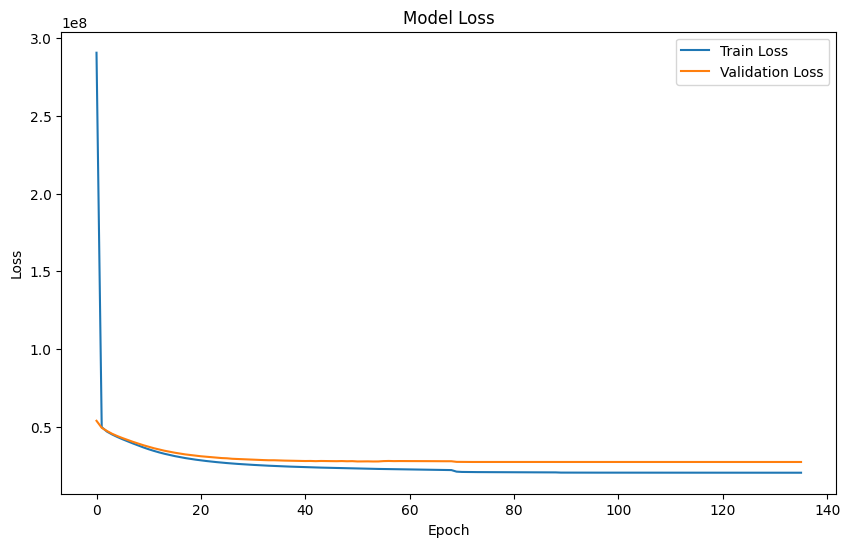

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: model_no_regularization
R²: 0.9112800156312459, RMSE: 5079.604354416003, MAE: 2882.580075963103


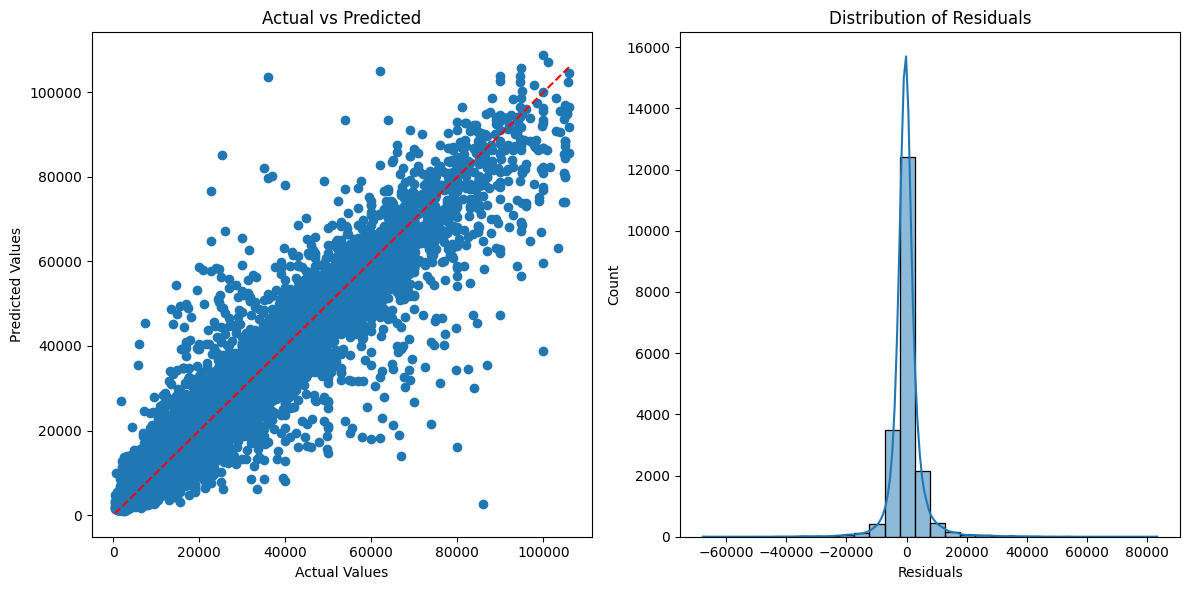

WORKING WITH MODEL model_dropout_only
Last epoch: 194


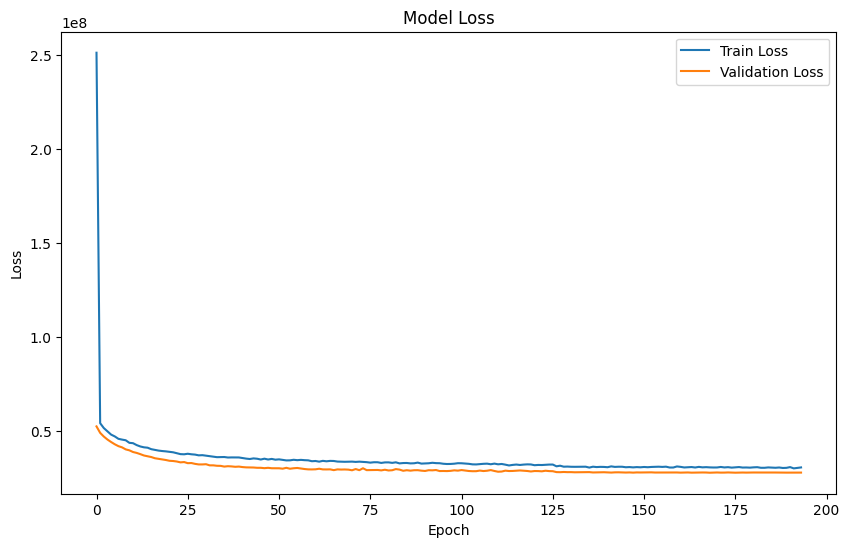

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: model_dropout_only
R²: 0.9109530649277077, RMSE: 5088.955420954499, MAE: 2879.9995791360525


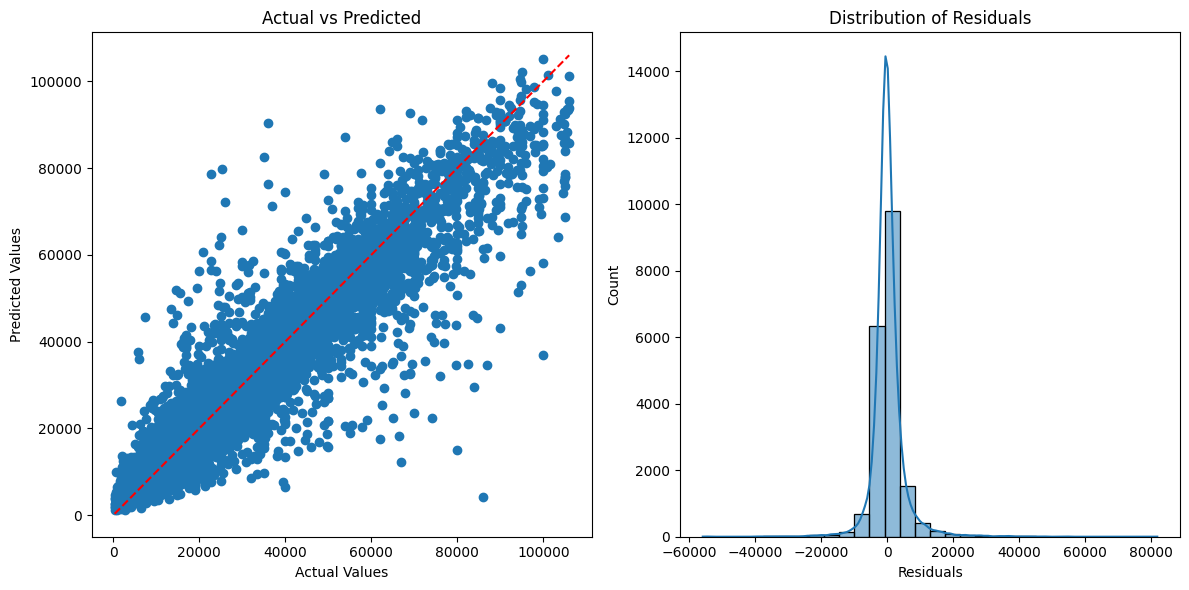

WORKING WITH MODEL model_batchnorm_only
Last epoch: 75


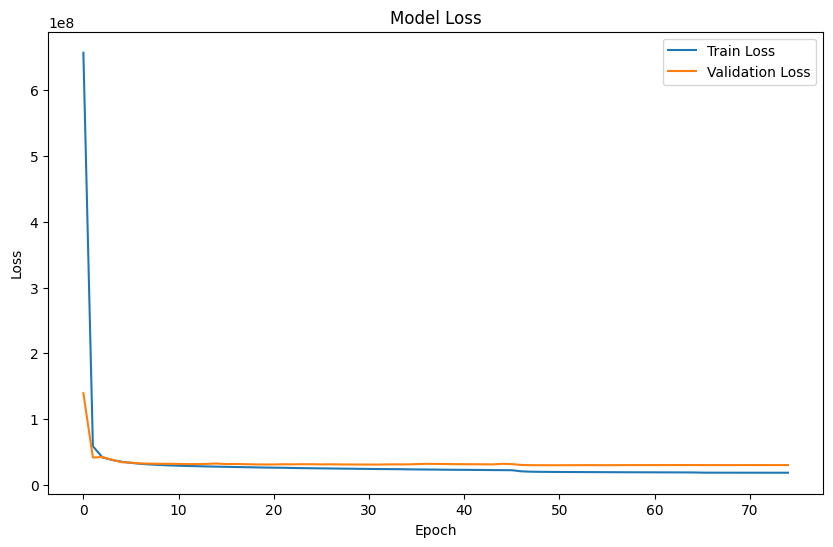

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: model_batchnorm_only
R²: 0.9003927944587555, RMSE: 5382.258305700124, MAE: 3078.5621061235906


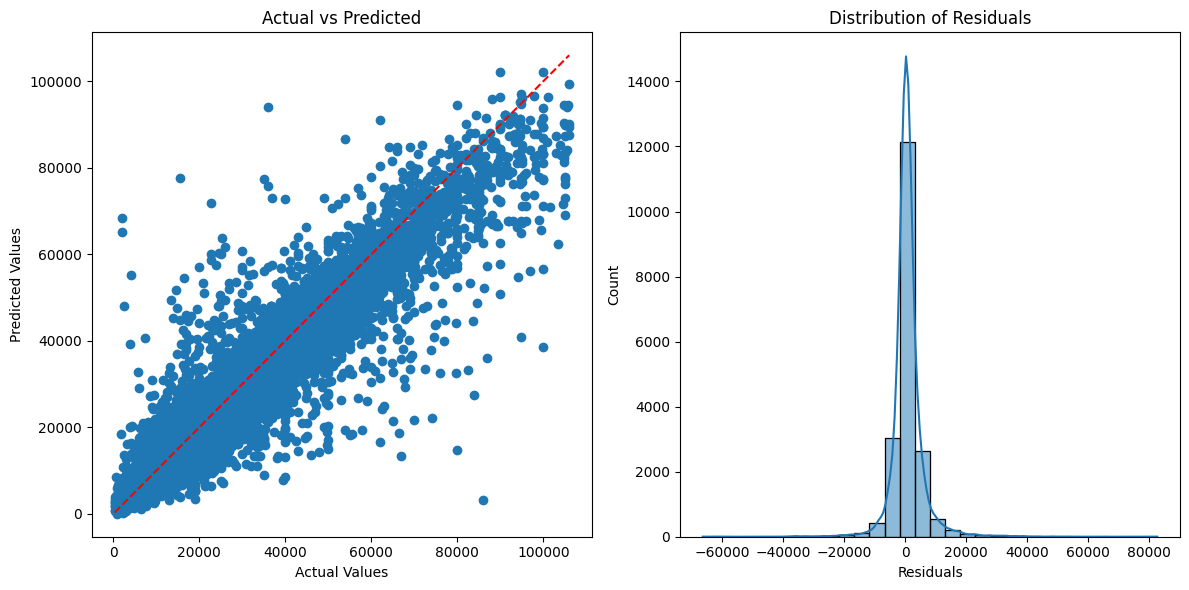

WORKING WITH MODEL model_dropout_batchnorm
Last epoch: 65


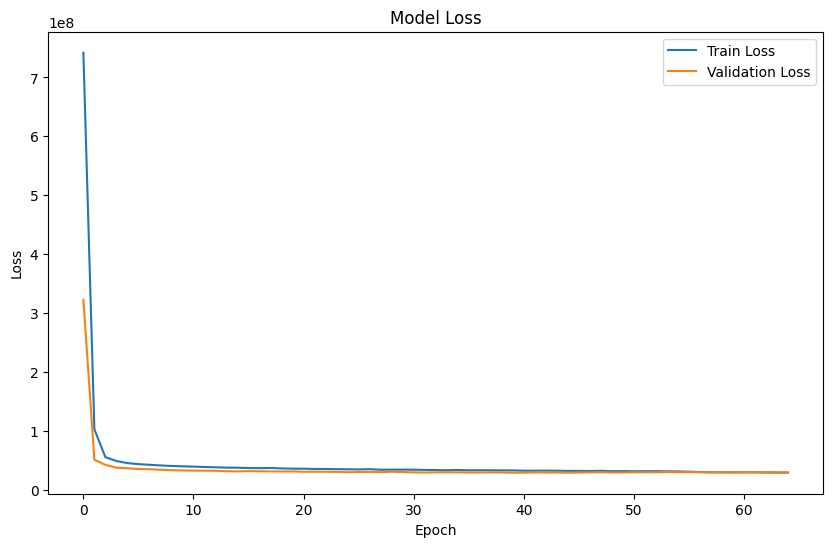

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: model_dropout_batchnorm
R²: 0.9052672689893696, RMSE: 5248.910737915907, MAE: 2992.9339917147818


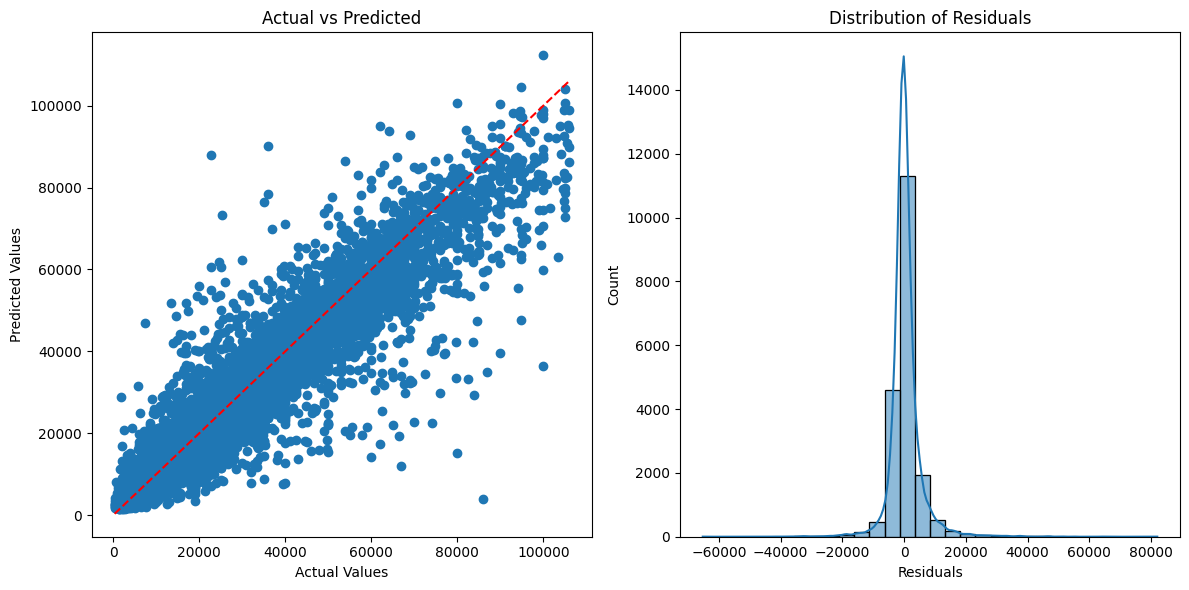

WORKING WITH MODEL model_l2_only
Last epoch: 109


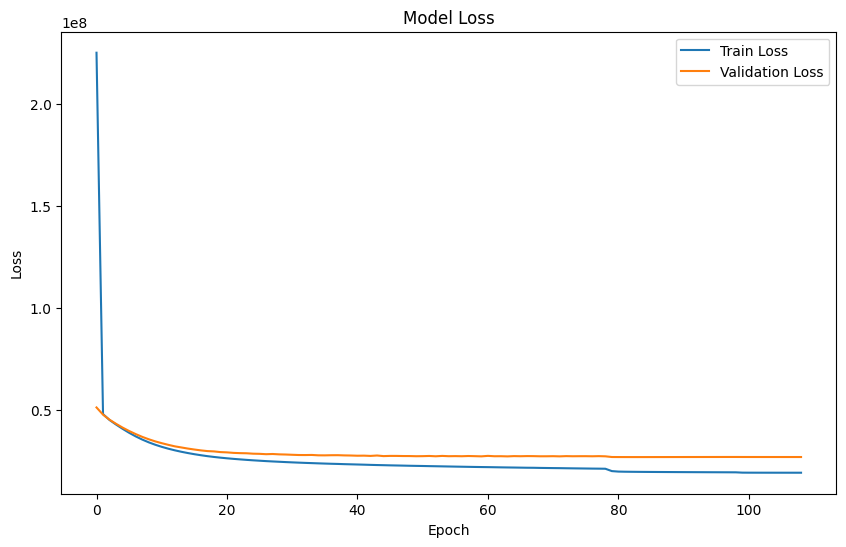

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: model_l2_only
R²: 0.9121551227277942, RMSE: 5054.490431280019, MAE: 2869.21099334612


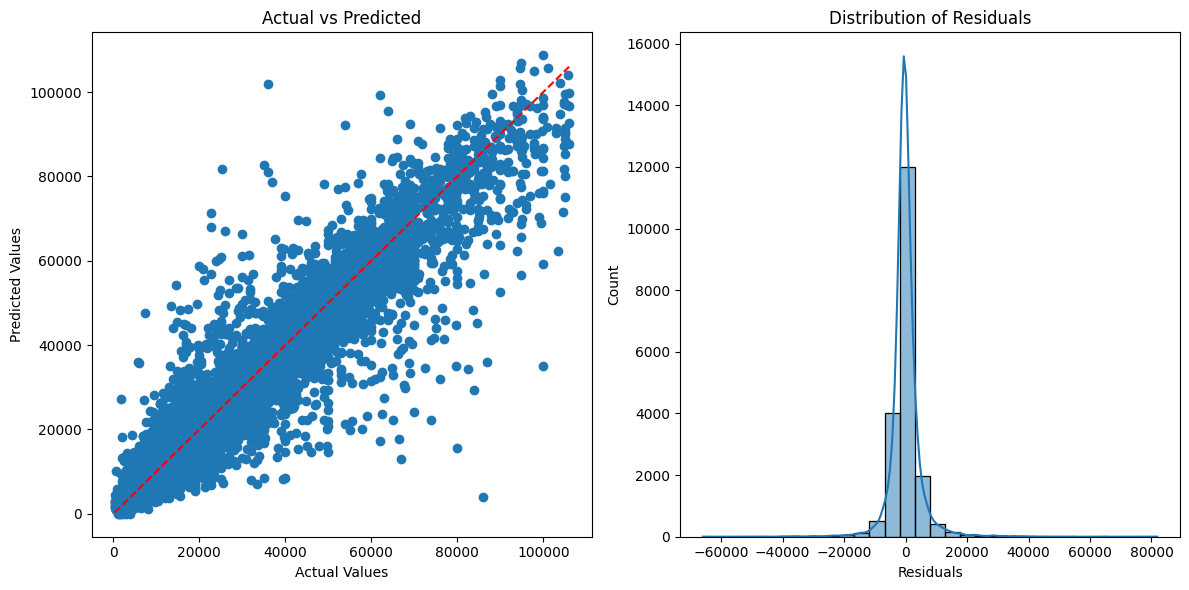

WORKING WITH MODEL model_all_combined
Last epoch: 66


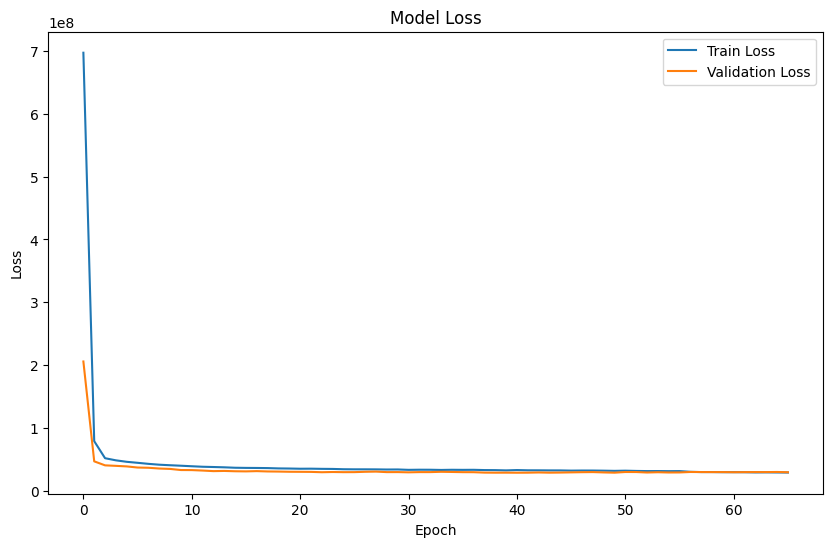

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: model_all_combined
R²: 0.905348957212284, RMSE: 5246.647176742669, MAE: 2990.492495606423


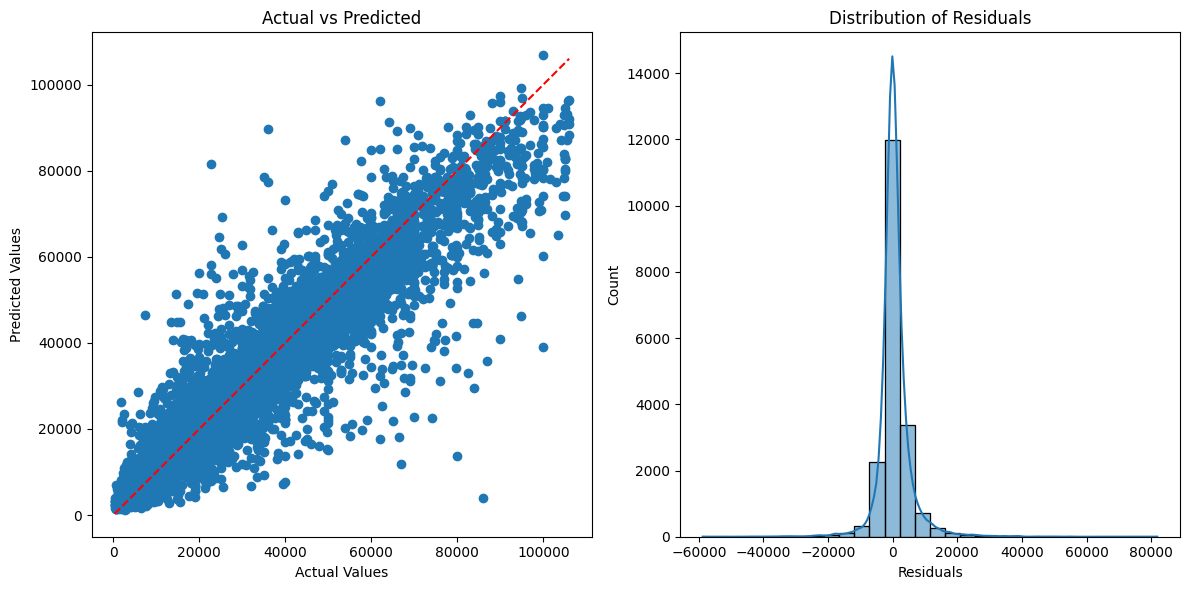

In [19]:
configs = {
    "model_no_regularization": {"dropout": False, "batchnorm": False, "l2": False},
    "model_dropout_only":      {"dropout": True,  "batchnorm": False, "l2": False},
    "model_batchnorm_only":    {"dropout": False, "batchnorm": True,  "l2": False},
    "model_dropout_batchnorm": {"dropout": True,  "batchnorm": True,  "l2": False},
    "model_l2_only":           {"dropout": False, "batchnorm": False, "l2": True},
    "model_all_combined":      {"dropout": True,  "batchnorm": True,  "l2": True},
}

for name, cfg in configs.items():
    print(f"WORKING WITH MODEL {name}")
    model = create_regularized_model(x_train.shape[1], cfg)
    hist = train_model(model, x_train, x_test, y_train, y_test, f'{name}')
    last_epoch = len(hist.history['loss'])
    print(f"Last epoch: {last_epoch}")
    view_loss_plot(hist)
    pre = predict_dl(model, x_test)
    calculate_metrics(model, x_test, y_test, pre, f'{name}', 'metrics_regularization.csv') 

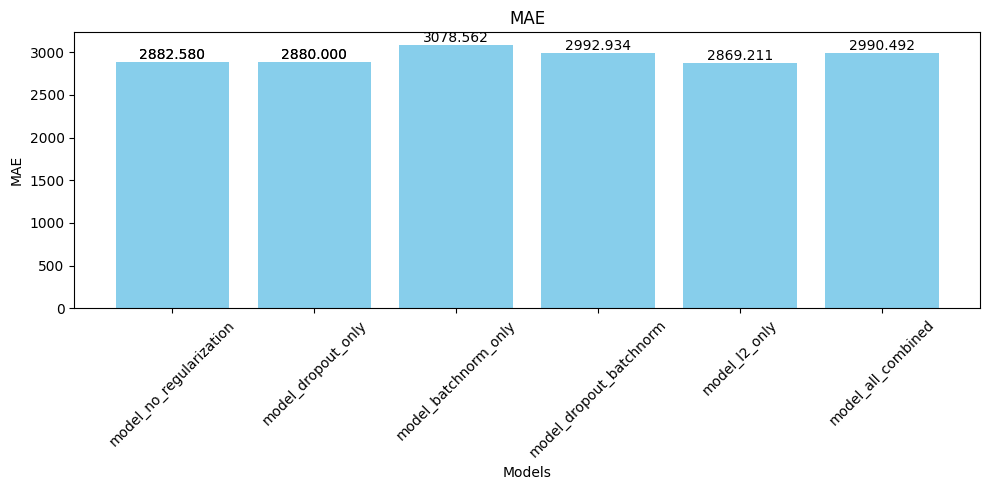

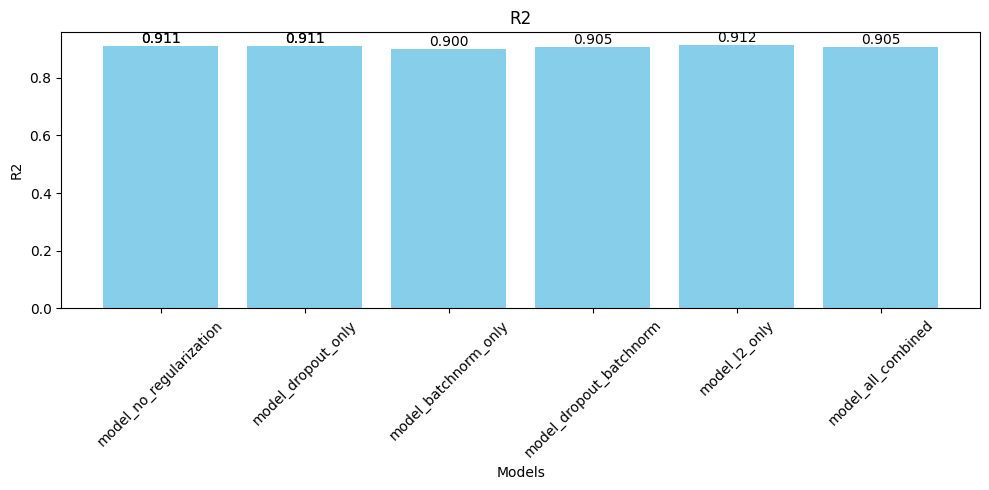

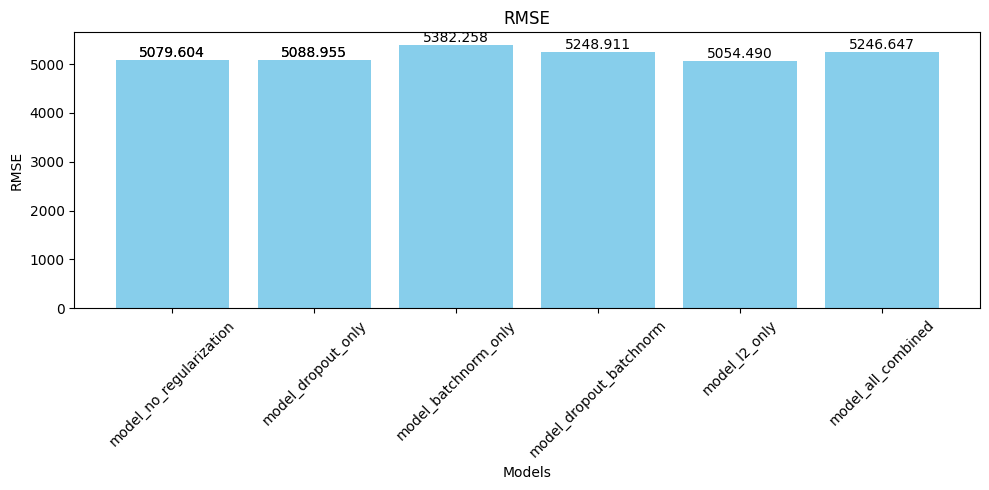

In [22]:
make_metric_plots_from_csv('/kaggle/input/metrics-regularization/metrics_regularization.csv')

**Results:**

The best-performing setup was the model with **L2 regularization only**, slightly improving over the baseline.

Dropout alone slightly degraded performance, suggesting the baseline model was not strongly overfitting.

BatchNormalization, both alone and combined with Dropout, significantly worsened performance — possibly due to interaction issues with architecture.
The full combination of all regularization techniques also degraded performance, likely due to over-regularization.

Overall, moderate L2 regularization appears to be the most effective strategy for this task, while more aggressive or stacked techniques can be harmful if the base model is already well-generalized. **This supports hypothesis H₁**

### 1.5 In total

| Component             | Best Value                       | Notes                                                                          |
|-----------------------|----------------------------------|--------------------------------------------------------------------------------|
| **Depth**             | 5-6 layers                         | Adding more layers did not improve performance; signs of saturation appeared   |
| **Width (neurons)**   | [1024, 256, 64, 8]               | Highest R² and lowest errors, especially with progressive narrowing            |
| **Pattern**           | Shrinking                        | Gradual reduction in layer width showed the best performance (same with base)                  |
| **Regularization**    | L2 (λ = 1e-4)                    | The only regularization method that consistently improved results              |
| **Dropout/BatchNorm** | Avoid or use minimally           | Most combinations with these techniques degraded performance (same with base)                   |



### 1.6 Constructing upgraded model

Architecture with new height - 6 layers. Width also enhanced.

In [35]:
def create_best_model(X_train_cols):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(X_train_cols,), kernel_regularizer=regularizers.l2(1e-4)),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(1)
    ])
    return model

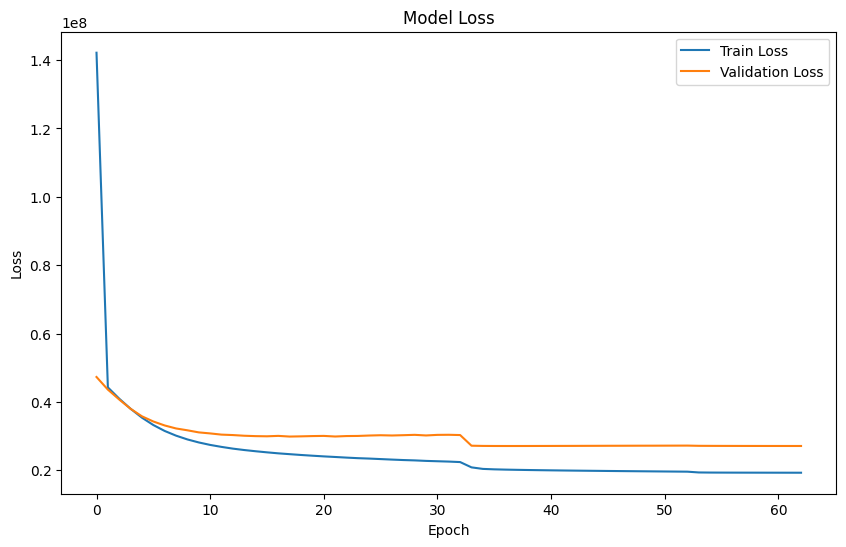

In [ ]:
name = 'model_upgraded'
model = create_best_model(x_train.shape[1])
hist = train_model(model, x_train, x_test, y_train, y_test, f'{name}')
view_loss_plot(hist)
pre = predict_dl(model, x_test)
calculate_metrics(model, x_test, y_test, pre, f'{name}', 'metrics_best.csv') 

Light model: only width enhanced

In [32]:
def create_best_model_v2(X_train_cols):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(X_train_cols,), kernel_regularizer=regularizers.l2(1e-4)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(1)
    ])
    return model


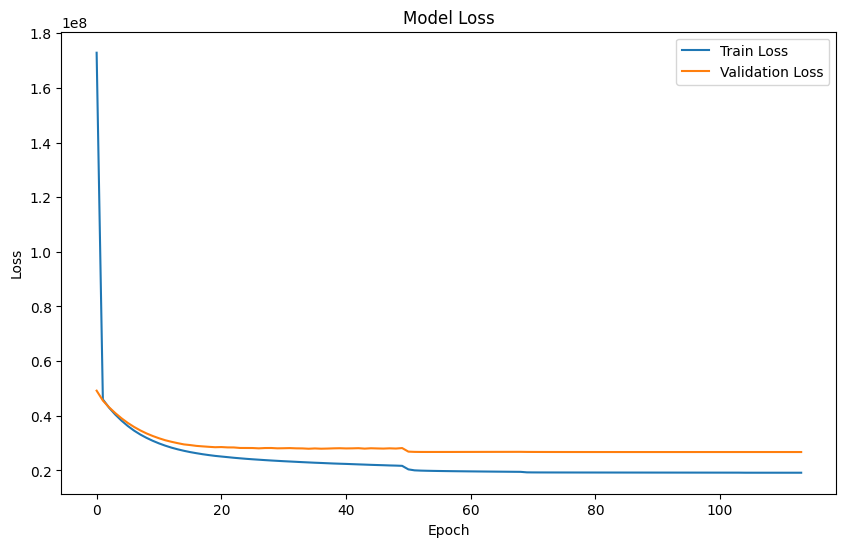

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: model_upgraded_v2
R²: 0.9126653489755174, RMSE: 5039.790146732541, MAE: 2843.509333192628


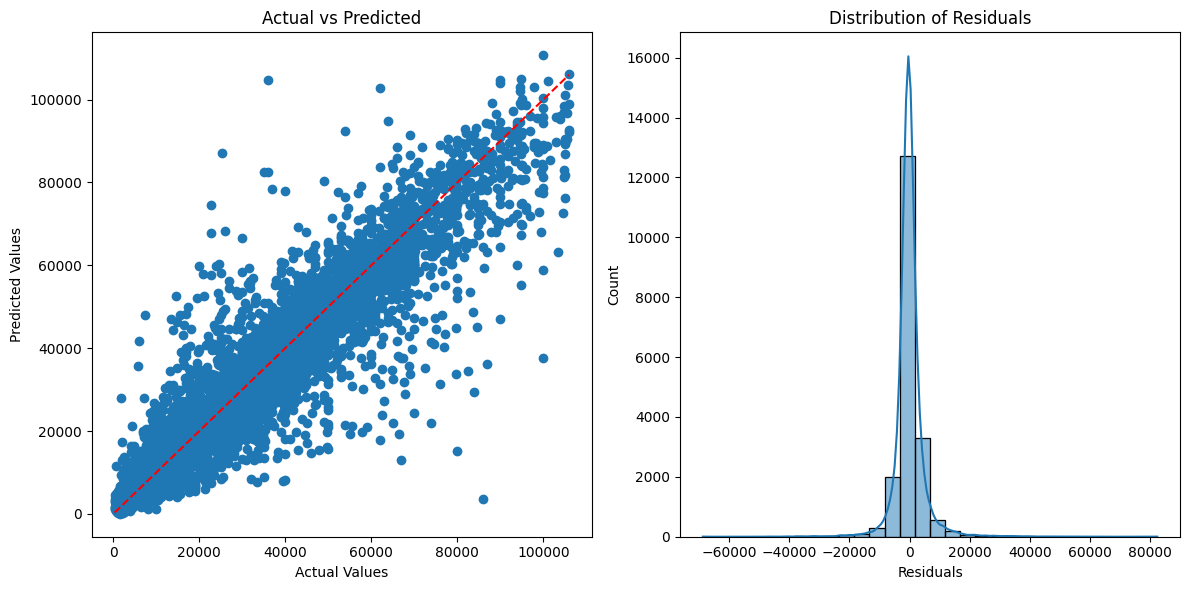

In [34]:
name = 'model_upgraded_v2'
model = create_best_model_v2(x_train.shape[1])
hist = train_model(model, x_train, x_test, y_train, y_test, f'{name}')
view_loss_plot(hist)
pre = predict_dl(model, x_test)
calculate_metrics(model, x_test, y_test, pre, f'{name}', 'metrics_best.csv') 

In [37]:
def compare_base_and_upgraded_models(base_csv_path, upgraded_csv_path):

    df_base = pd.read_csv(base_csv_path)
    df_upgraded = pd.read_csv(upgraded_csv_path)
    df_all = pd.concat([df_base, df_upgraded], ignore_index=True)

    metrics = ['R2', 'RMSE', 'MAE']

    for metric in metrics:
        plt.figure(figsize=(8, 5))
        bars = plt.bar(df_all['Model'], df_all[metric], color='skyblue')
        plt.title(f'{metric} Comparison')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.xticks(rotation=30)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', 
                     ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

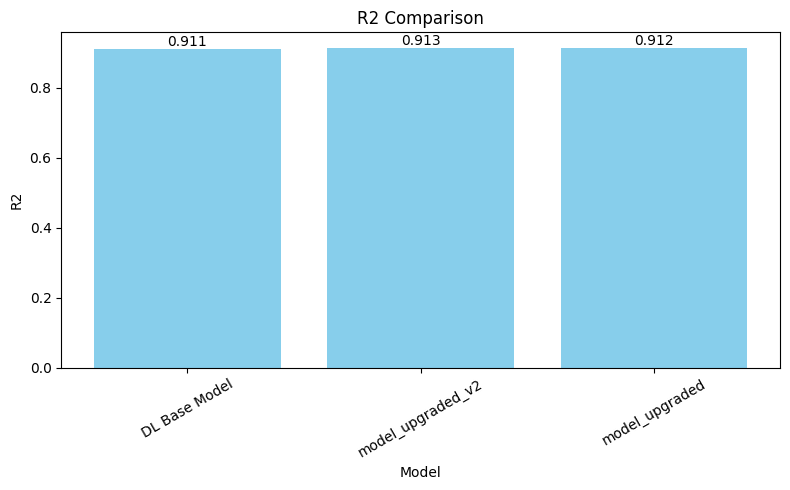

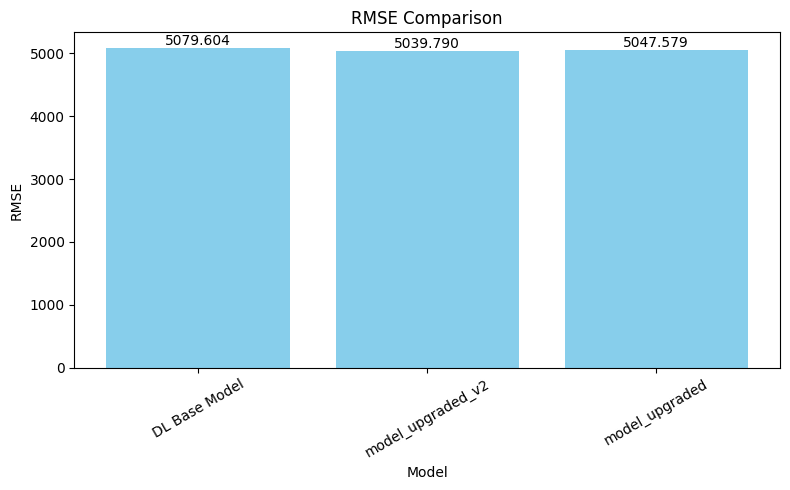

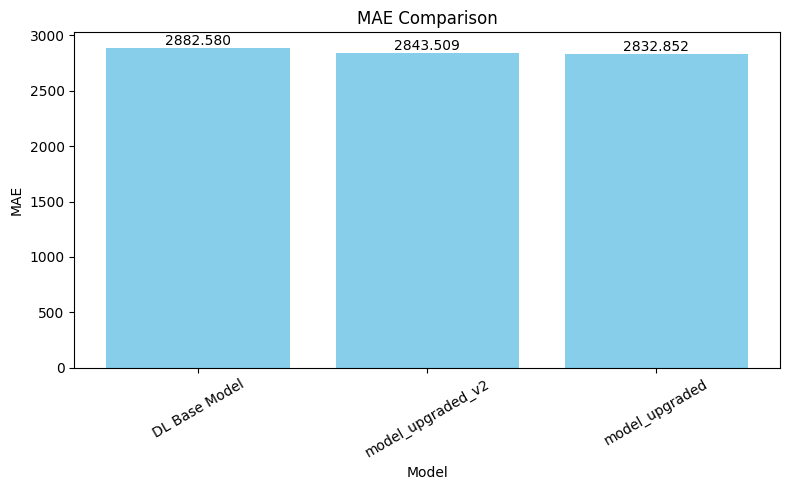

In [38]:
compare_base_and_upgraded_models("/kaggle/input/metrics-base/metrics_base.csv", "/kaggle/input/metrics-upgraded/metrics_upgraded.csv")

The upgraded models show a small but consistent improvement over the base model. Both upgraded and upgraded_v2 have higher R² and lower RMSE, indicating better generalization and more accurate predictions. While the MAE differences are minor, they still lean slightly in favor of the newer versions.

Thus, the architecture refinements — such as better width configuration, use of L2 regularization, and the shrinking pattern — do yield measurable benefits, even if the gains are modest.

To improve current results let's move to hyperparams tuning

## 2. Hyperparams tuning

To further improve the model's performance, we will tune its hyperparameters. Specifically, we will focus on optimizing the L2 regularization strength, the learning rate, and the batch size. These parameters significantly affect the model's ability to generalize and converge efficiently during training.

### 2.1 Tuning for model 1 

In [49]:
def create_best_model_tuned(hp):
    l2_value = hp.Float('l2', 1e-6, 1e-2, sampling='log')

    model = Sequential([
        layers.Dense(1024, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(1)
    ])
    
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32)
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.09, patience=15, min_lr=1e-6)

tuner = kt.BayesianOptimization(
    create_best_model_tuned,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='model_tuning'
)

tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=200,
    callbacks=[es, lr],
    verbose=0
)

In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = best_trial.hyperparameters.values

best_model.save(f'model_best_tuned.h5')

In [ ]:
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)

608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Model: model_upgraded
R²: 0.9127181717568315, RMSE: 5038.265803325975, MAE: 2830.5961761380477


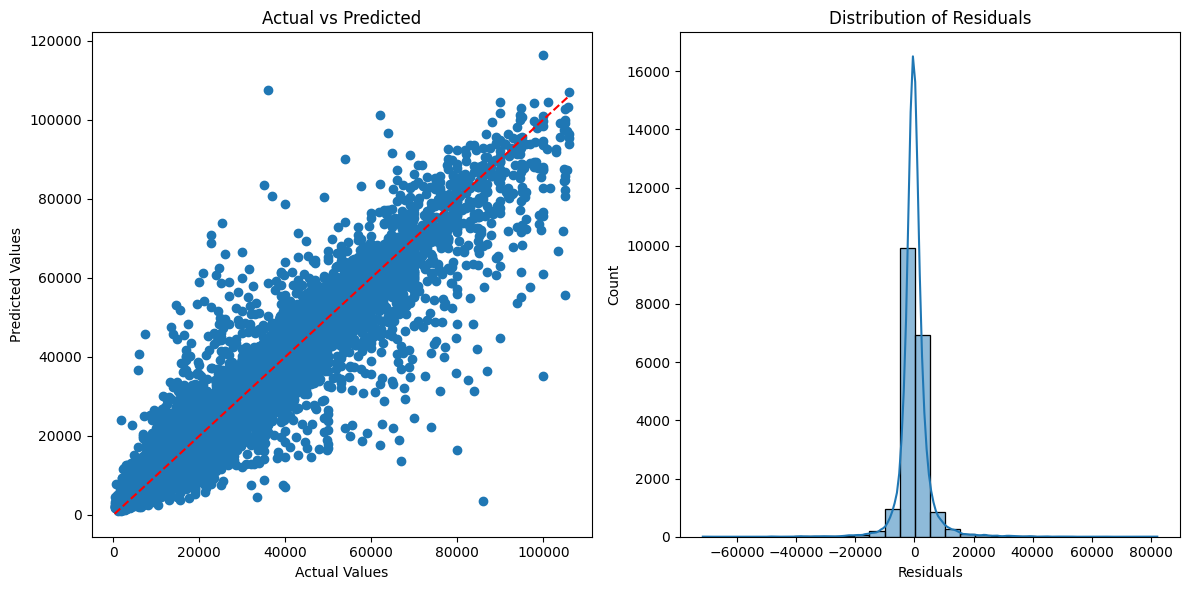

MODEL 1 TUNED HYPERPARAMS
l2: 4.5437032601532136e-05
learning_rate: 0.00028298687933680513
batch_size: 256


In [13]:
tuned_best_model = load_model('/kaggle/input/model_tuned/keras/default/1/model_best_tuned (2).h5')
pre = predict_dl(tuned_best_model, x_test)
calculate_metrics(tuned_best_model, x_test, y_test, pre, 'model_upgraded', 'metrics_best_tuned.csv') 

print("MODEL 1 TUNED HYPERPARAMS")
with open('/kaggle/input/hyperparams-1/best_hyperparameters.json', 'r') as f:
    best_hyperparameters = json.load(f)

for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

### 2.2 Tuning for model 2

In [ ]:
def create_best_model2_tuned(hp):
    l2_value = hp.Float('l2', 1e-6, 1e-2, sampling='log')

    model = Sequential([
        layers.Dense(1024, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
        layers.Dense(1)
    ])
    
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32)
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.09, patience=15, min_lr=1e-6)

tuner = kt.BayesianOptimization(
    create_best_model2_tuned,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='tuner1_dir',
    project_name='model1_tuning'
)

tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=200,
    callbacks=[es, lr],
    verbose=0
)

In [ ]:
best_trial2 = tuner.oracle.get_best_trials(num_trials=1)[0]
best_model2 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters2 = best_trial2.hyperparameters.values

best_model2.save(f'model_best1_tuned.h5')

In [ ]:
with open('best_hyperparameters2.json', 'w') as f:
    json.dump(best_hyperparameters2, f)

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: model_upgraded_v2
R²: 0.9127681916857655, RMSE: 5036.821918503728, MAE: 2864.5255124030623


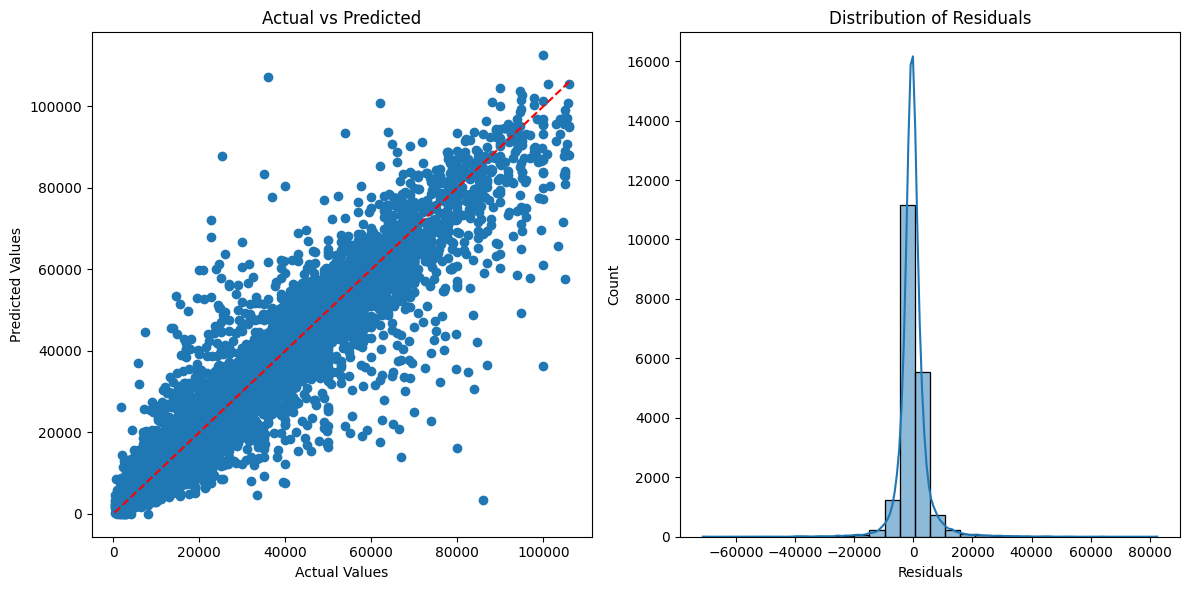

MODEL 2 TUNED HYPERPARAMS
l2: 0.00014201554806804378
learning_rate: 0.00028546666455663456
batch_size: 64


In [14]:
tuned_best_model2 = load_model('/kaggle/input/model-tuned-2/keras/default/1/model_best_tuned1.h5')
pre = predict_dl(tuned_best_model2, x_test)
calculate_metrics(tuned_best_model2, x_test, y_test, pre, 'model_upgraded_v2', 'metrics_best_tuned.csv') 

print("MODEL 2 TUNED HYPERPARAMS")
with open('/kaggle/input/hyperparams-2/best_hyperparameters1.json', 'r') as f:
    best_hyperparameters = json.load(f)

for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

### 2.3 Final Comparison

In [38]:
def compare_model_metrics(path_before: str, path_after: str):
    df_before = pd.read_csv(path_before)
    df_after = pd.read_csv(path_after)

    df_merged = pd.merge(df_before, df_after, on='Model', suffixes=('_before', '_after'))

    common_metrics = [col for col in df_before.columns if col != 'Model']

    for metric in common_metrics:
        df_merged[f'{metric}_diff'] = df_merged[f'{metric}_before'] - df_merged[f'{metric}_after']

    ordered_columns = ['Model']
    for metric in common_metrics:
        ordered_columns += [f'{metric}_before', f'{metric}_after', f'{metric}_diff']

    df_ordered = df_merged[ordered_columns]
    return df_ordered

In [39]:
df = compare_model_metrics('/kaggle/input/metrics-upgraded/metrics_upgraded.csv', '/kaggle/input/metrics-tuned1/metrics_tuned.csv')
df.head()

Model  R2_before  R2_after   R2_diff  RMSE_before   RMSE_after  \
0  model_upgraded_v2   0.912665  0.912768 -0.000103  5039.790147  5036.821919   
1     model_upgraded   0.912395  0.912718 -0.000323  5047.578953  5038.265803   

   RMSE_diff   MAE_before    MAE_after   MAE_diff  
0   2.968228  2843.509333  2864.525512 -21.016179  
1   9.313150  2832.852335  2830.596176   2.256159

R²:

model_upgraded_v2: +0.000103 ✅

model_upgraded: +0.000323 ✅

Both improved slightly, but model_upgraded had a larger improvement.

RMSE:

model_upgraded_v2: −2.97 ✅

model_upgraded: −9.31 ✅

Both improved, but again model_upgraded had a greater reduction in error.

MAE:

model_upgraded_v2: +21.02 ❌

model_upgraded: −2.26 ✅


**Conclusion:** *model_upgraded* is better overall.
Although both models improved on R² and RMSE, model_upgraded had:

Greater improvement in R² and RMSE

Slight improvement in MAE (while model_upgraded_v2 worsened)

Although both models exhibit marginal improvements in key performance metrics after parameter tuning, the overall impact is relatively small. This suggests that the current tuning approach yields only incremental gains in predictive performance.

##  3. Final comparison

In [53]:
def make_metric_plots_from_multiple_csv(csv_paths):
    dfs = [pd.read_csv(path) for path in csv_paths]
    df = pd.concat(dfs, ignore_index=True)

    model_name_map = {
        'model_upgraded': 'Upgraded DL Model 1',
        'model_upgraded_v2': 'Upgraded DL Model 2',
    }

    df['Model'] = df['Model'].replace(model_name_map)
    
    metrics = ['MAE', 'R2', 'RMSE']
    
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        bars = plt.bar(df['Model'], df[metric], color='skyblue')
        plt.title(metric)
        plt.xlabel('Models')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', 
                     ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

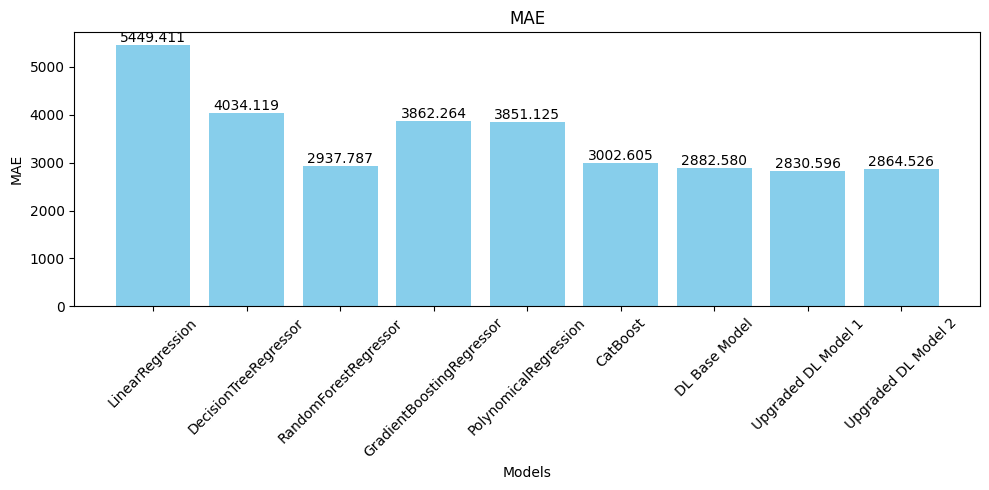

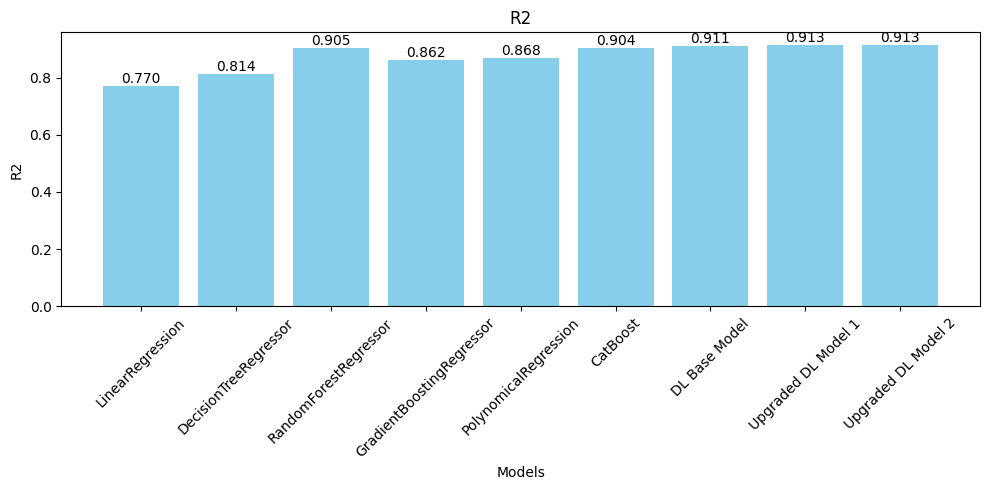

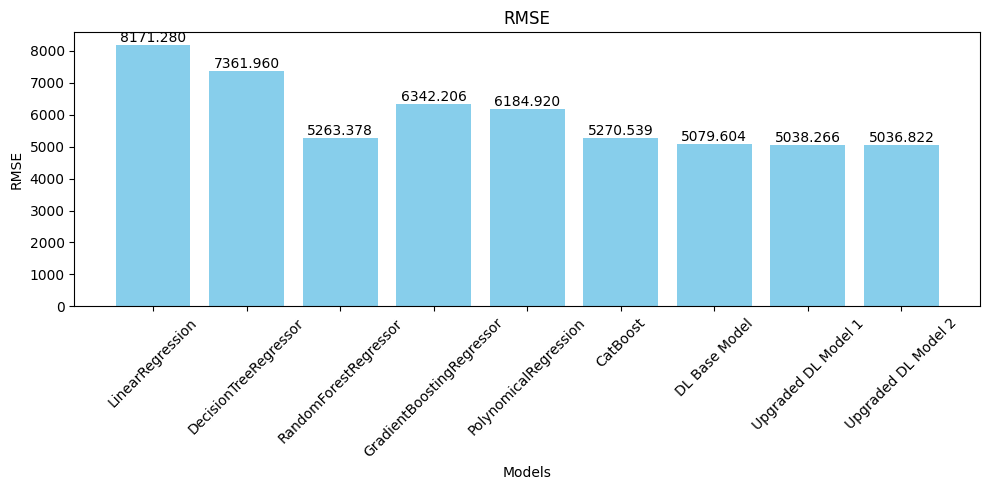

In [54]:
make_metric_plots_from_multiple_csv(
    ['/kaggle/input/metrics-standard/metrics_stardard.csv', 
     '/kaggle/input/metrics-base/metrics_base.csv',
     '/kaggle/input/metrics-tuned1/metrics_tuned.csv']
)


The neural network outperforms traditional machine learning models on this regression task, as demonstrated by superior performance metrics such as R², RMSE, and MAE. While the baseline machine learning models provide solid results, the neural network consistently achieves better predictive accuracy, showing its ability to capture more complex patterns in the data.

Moreover, with proper tuning of the architecture and hyperparameters, the performance of the neural network can be further enhanced. Small but noticeable improvements in key metrics suggest that additional optimization, including fine-tuning layers, activation functions, and learning rates, could yield even better results.

This indicates that neural networks, when carefully tuned, have the potential to significantly outperform traditional models in regression tasks by leveraging their capacity to model non-linear relationships in data.